In [1]:
import sys
# sys.path.insert(0,'../skylens')

import tracemalloc
import pickle
from skylens import *
from survey_utils import *
from scipy.stats import norm,mode,skew,kurtosis,percentileofscore
import seaborn as sns
import importlib
reload=importlib.reload

d2r=np.pi/180
colors=sns.color_palette()
markers=['o','s','^','>','v']

In [2]:
def corr_matrix(cov_mat=[]): #correlation matrix
    diag=np.diag(cov_mat)
    return cov_mat/np.sqrt(np.outer(diag,diag))

In [3]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

In [5]:
fig_home='./figures/'

In [6]:
ncpu=10
LC,scheduler_info=start_client(Scheduler_file=None,local_directory=None,ncpu=None,n_workers=ncpu,threads_per_worker=1,
                              memory_limit='120gb',dashboard_address=8811,processes=True)
client=client_get(scheduler_info=scheduler_info)


Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid1943/


In [7]:
client

Client Scheduler: tcp://127.0.0.1:40659 Dashboard: http://127.0.0.1:8811/status,Cluster Workers: 10 Cores: 10 Memory: 1.20 TB


In [8]:
outp={}
cl_sim_W={}
zs_bin={}
zl_bin={}
cl0={}
cl0_win0={}
# l_bins={}
use_shot_noise={}
skylens_kwargs={}

In [9]:
labels={}
labels[corr_gg]=r'$gg$'
labels[corr_ll]=r'$\gamma\gamma$'
labels[corr_ggl]=r'$g \gamma$'

corr_labels={}
corr_labels[corr_ll]=r'$\gamma\gamma^{EE}$'
corr_labels['shear_B']=r'$\gamma\gamma^{BB}$'
corr_labels[corr_gg]=r'$gg$'
corr_labels[corr_ggl]=r'$g\gamma$'

corr_fnames={}
corr_fnames[corr_ll]='ll'
corr_fnames[corr_gg]='gg'
corr_fnames[corr_ggl]='ggl'

In [26]:
file_home='/verafs/scratch/phy200040p/sukhdeep/physics2/skylens/tests/'
fnames={0:file_home+'xi0_cl0_sims_newN10_ns512_lmax512_wlmax1025_fsky0.3_noSN_deltaW.pkl'}
# fnames[1]=file_home+'cl0_sims_newN100_ns1024_lmax1000_wlmax2001_fsky0.3_noSN_cWin_delta.pkl'
# fnames={0:file_home+'cl0_sims_newN1000_ns1024_lmax1000_wlmax2001_fsky0.3_deltaW.pkl'}
# fnames[1]=file_home+'cl0_sims_newN1000_ns1024_lmax1000_wlmax2001_fsky0.3_cWin_deltaW.pkl'


for i in fnames.keys():
    with open(fnames[i],'rb') as f:
        outp[i]=pickle.load(f)

    cl_sim_W[i]=outp[i]['simW']
    zs_bin[i]=outp[i]['shear_zbins']
    zl_bin[i]=outp[i]['galaxy_zbins']
    cl0[i]=outp[i]['cl0']
    cl0_win0[i]=outp[i]['cl0_win']
#     l_bins[i]=cl_sim_W[i]['l_bins']
    use_shot_noise[i]=cl_sim_W[i]['use_shot_noise']
    skylens_kwargs[i]=outp[i]['Skylens_kwargs']

In [27]:
wlt=hp.anafast(zs_bin[0][0]['window'],zl_bin[0][0]['window'])
wlt0=hp.anafast(zs_bin[0][0]['window'],zs_bin[0][0]['window'])
mask=zs_bin[0][0]['window']!=hp.UNSEEN
wlt00=hp.anafast(mask)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


[]

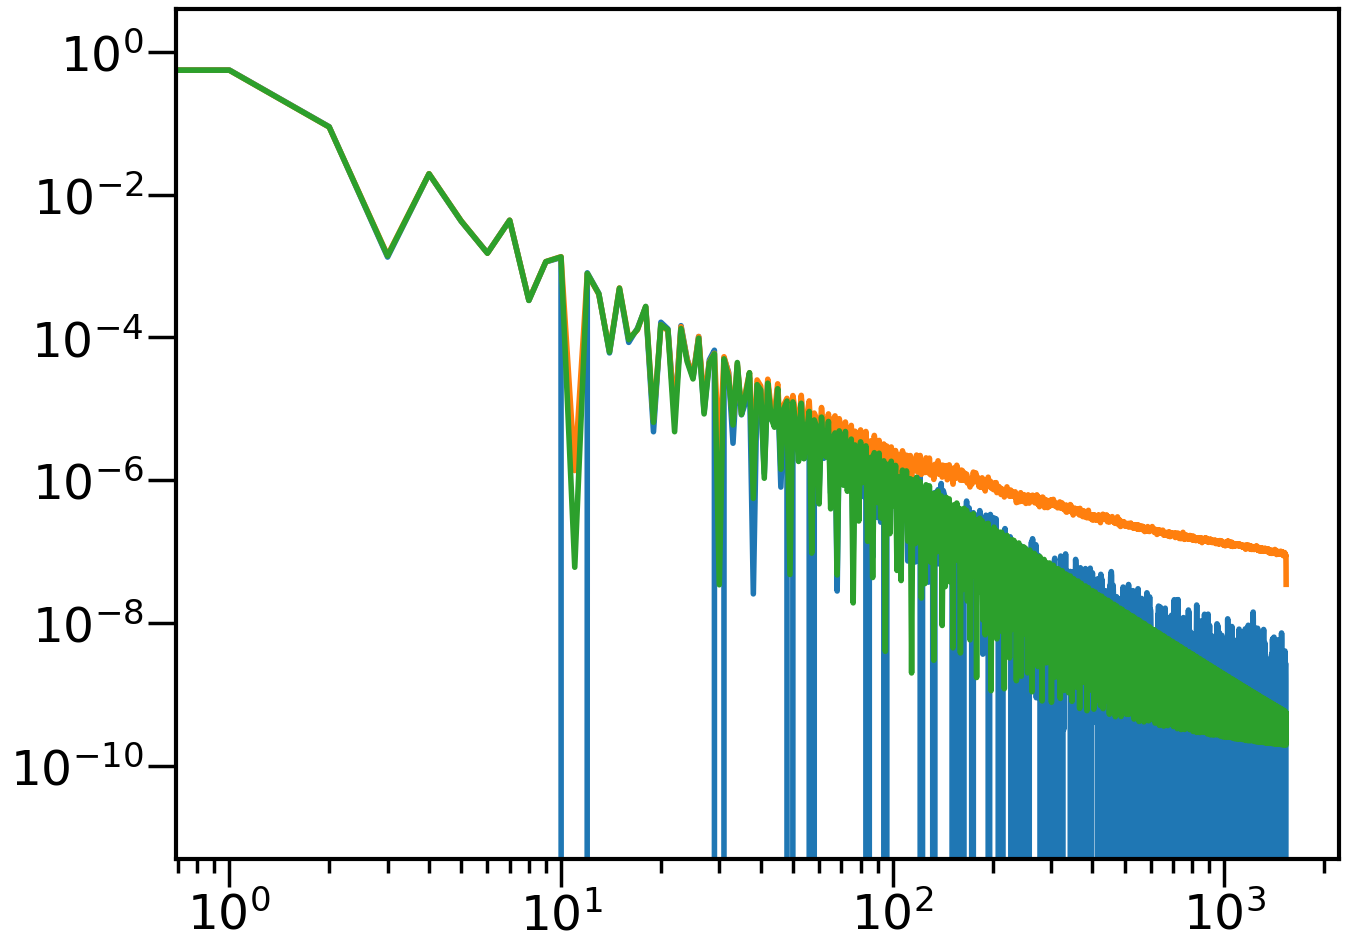

In [28]:
plot(wlt)
plot(wlt0)
plot(wlt00)
loglog()

In [29]:
mm=hp.synfast(cl_sim_W[0]['cl0'][0],nside=1024)

/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [30]:
nsim=1000

('shear', 'shear') 0
('shear', 'shear') 1
('galaxy', 'shear') 2
('galaxy', 'galaxy') 3
saved to  ./figures//xi0_cl0_sims_newN10_ns512_lmax512_wlmax1025_fsky03_noSN_deltaW.pdf


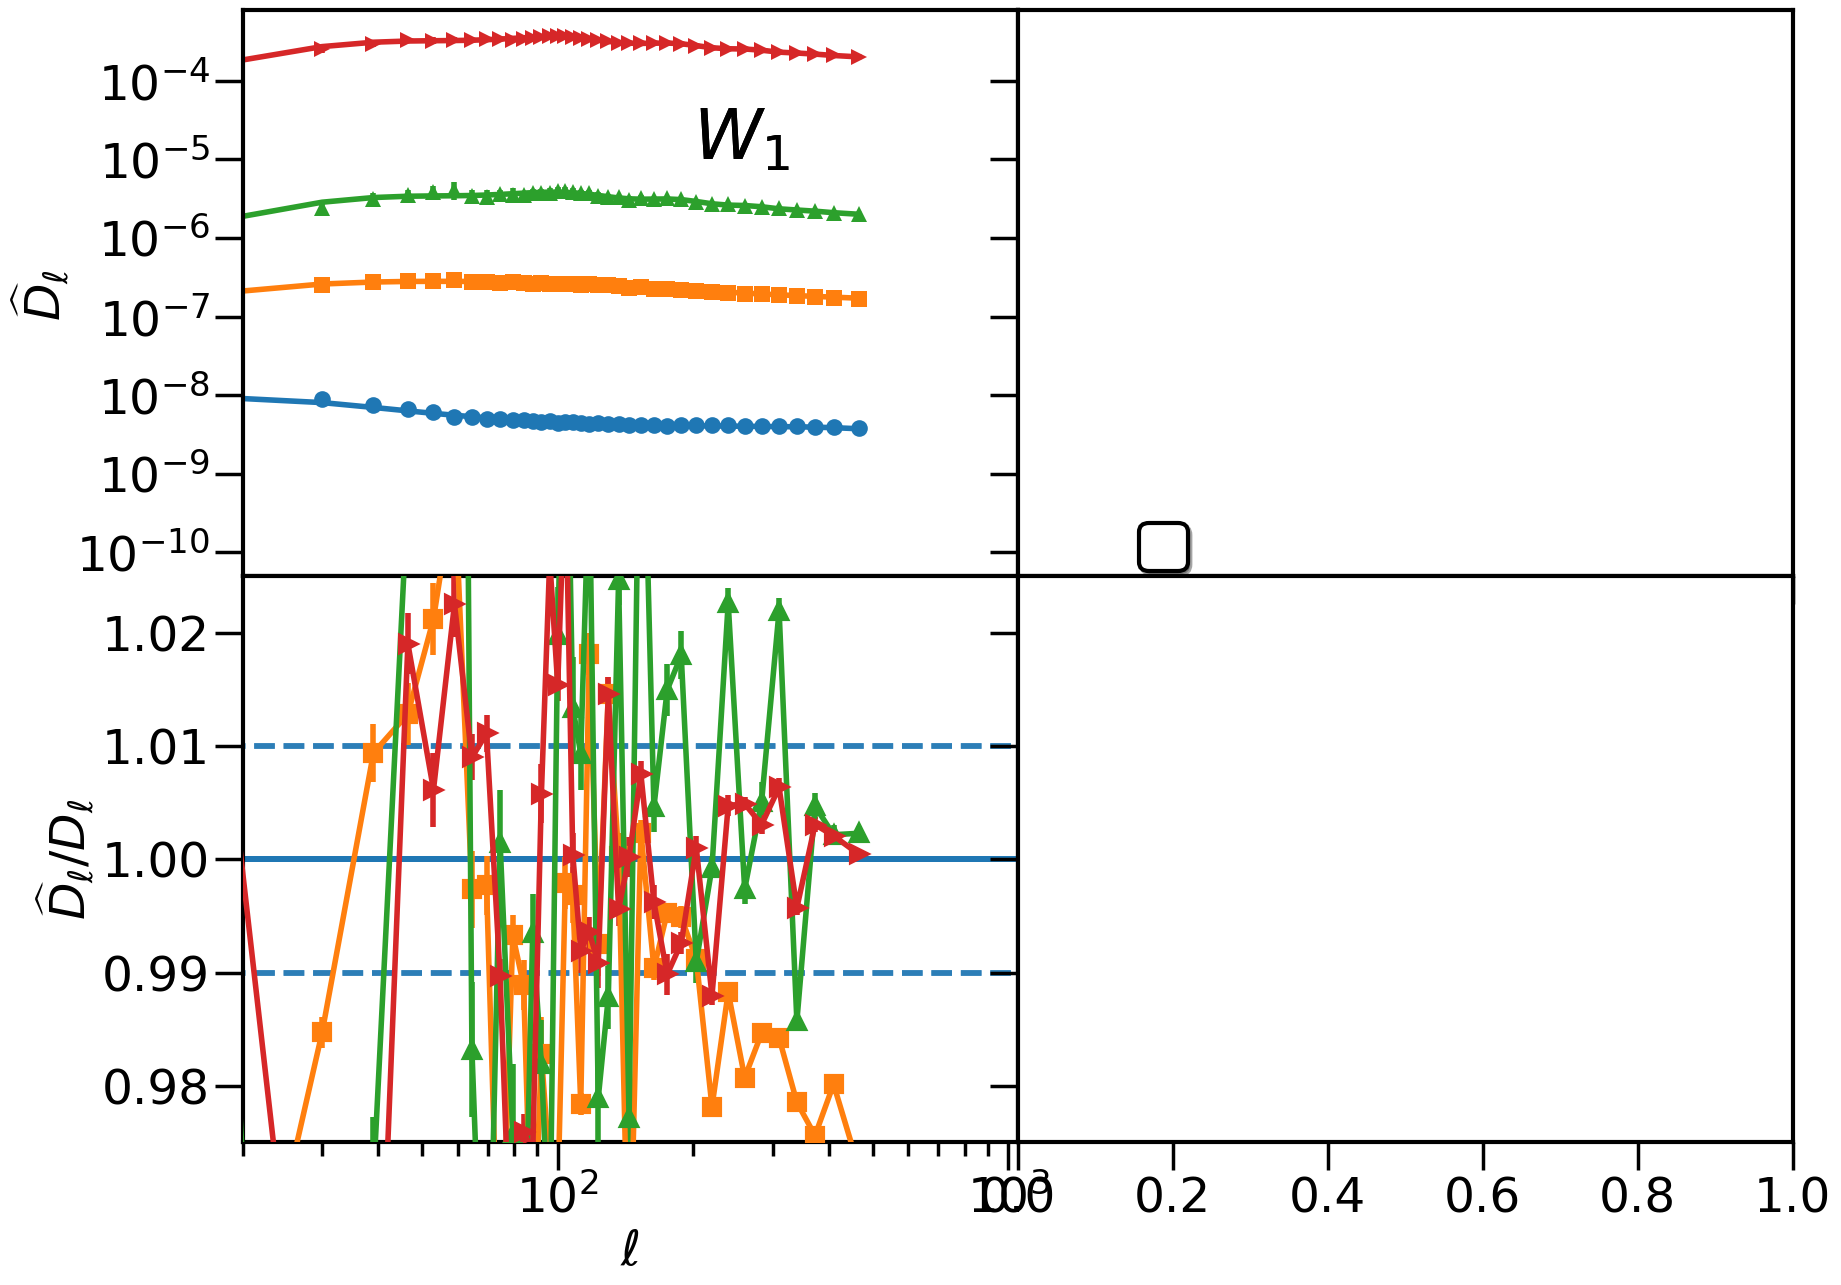

In [31]:
f=1
corr_i=0
fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
for corr in [corr_ll,corr_ll,corr_ggl,corr_gg]:
    color=colors[corr_i]
    marker=markers[corr_i]
    print(corr,corr_i)
    for simj in fnames.keys():#np.arange(1):
        cl_simi=cl_sim_W[simj]
#         else:
#             cl_simi=cl_sim_Ww
        l_bins=cl_simi['l_bins']
        l=cl_simi['l']
        lb=0.5*(l_bins[1:]+l_bins[:-1])
        pS=ax[0,simj]
        pR=ax[1,simj]
        
#         nsim=cl_simi['nsim']
        f=lb
        f2=f/sqrt(nsim)
        i=0
        nlb=len(lb)
        if corr==corr_ll and corr_i==0:
            pS.errorbar(lb,f*cl_simi['pcl_b_stats']['mean'].reshape(4,nlb)[corr_i],f*cl_simi['pcl_b_stats']['std'].reshape(4,nlb)[corr_i],
                    fmt=marker,c=color,label=corr_labels['shear_B'])
#             pcli=cl_simi['cl0_b'][len(lb):2*len(lb)]@cl_simi['coupling_M']['full']['coupling_M_binned']['iMaster']['shear_B']
            clt=cl_simi['cl0_b'][corr]
#             clt=cl_simi['cl0_b'].reshape(4,nlb)[1]
            pcli=clt@cl_simi['coupling_M']['full']['coupling_M_binned']['iMaster']['shear_B']
            pS.plot(lb,f*pcli,c=color)
            f=0#1./pcli
        else:
            pS.errorbar(lb,f*cl_simi['pcl_b_stats']['mean'].reshape(4,nlb)[corr_i],f*cl_simi['pcl_b_stats']['std'].reshape(4,nlb)[corr_i],
                    fmt=marker,c=color,label=corr_labels[corr])
            pS.plot(lb,f*cl_simi['pcl0'][corr],c=color)
            f=1./cl_simi['pcl0'][corr]
        f2=f/sqrt(nsim)
        pR.errorbar(lb*1.0,f*cl_simi['pcl_b_stats']['mean'].reshape(4,nlb)[corr_i],
                    f2*cl_simi['pcl_b_stats']['std'].reshape(4,nlb)[corr_i],fmt=marker+'-',c=color,mfc=None,mew=3,zorder=10)

        pR.set_xscale('log')
        # yscale('log')
        pR.set_ylim(.975,1.025)
        pR.hlines(1,10,3000)
        pR.hlines(1.01,10,3000,ls='--',alpha=0.5,zorder=-1)
        pR.hlines(.99,10,3000,ls='--',alpha=0.5,zorder=-1)
        
        pS.set_yscale('log')
        pS.set_ylim(5.e-11,8.e-4)
#         tf=.9
#         if corr==corr_ll:
#             pS.set_ylim(3.e-7,1.e-6)
#             pR.set_ylim(.9,1.11)
#             tf=1
        pR.set_xlim(20,1050)
        pR.set_xlabel(r'$\ell$')
        if simj==0:
            pR.set_ylabel(r'$\widehat D_\ell/D_\ell$')
            pS.set_ylabel(r'$\widehat D_\ell$ ')
        if corr==corr_ll:
            if simj==0:
                pS.text(x=200,y=1.e-5,s=r'$W_'+str(simj+1)+'$',fontsize=50)
            if simj==1:
                pS.text(x=200,y=1.e-5,s=r'$W_'+str(simj+1)+'$',fontsize=50)
    corr_i+=1
ax[0,1].legend(ncol=2,loc='lower left',bbox_to_anchor=(0.15,-0))
ax[0,0].set_yticks(np.logspace(-10,-4,7))

fname=fnames[0].split('.pkl')[0]
fname=fname.split('tests')[1]
fname=fname.split('.')
fname=fname[0]+fname[1]
fname=fig_home+fname
fname+='.pdf'
# fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

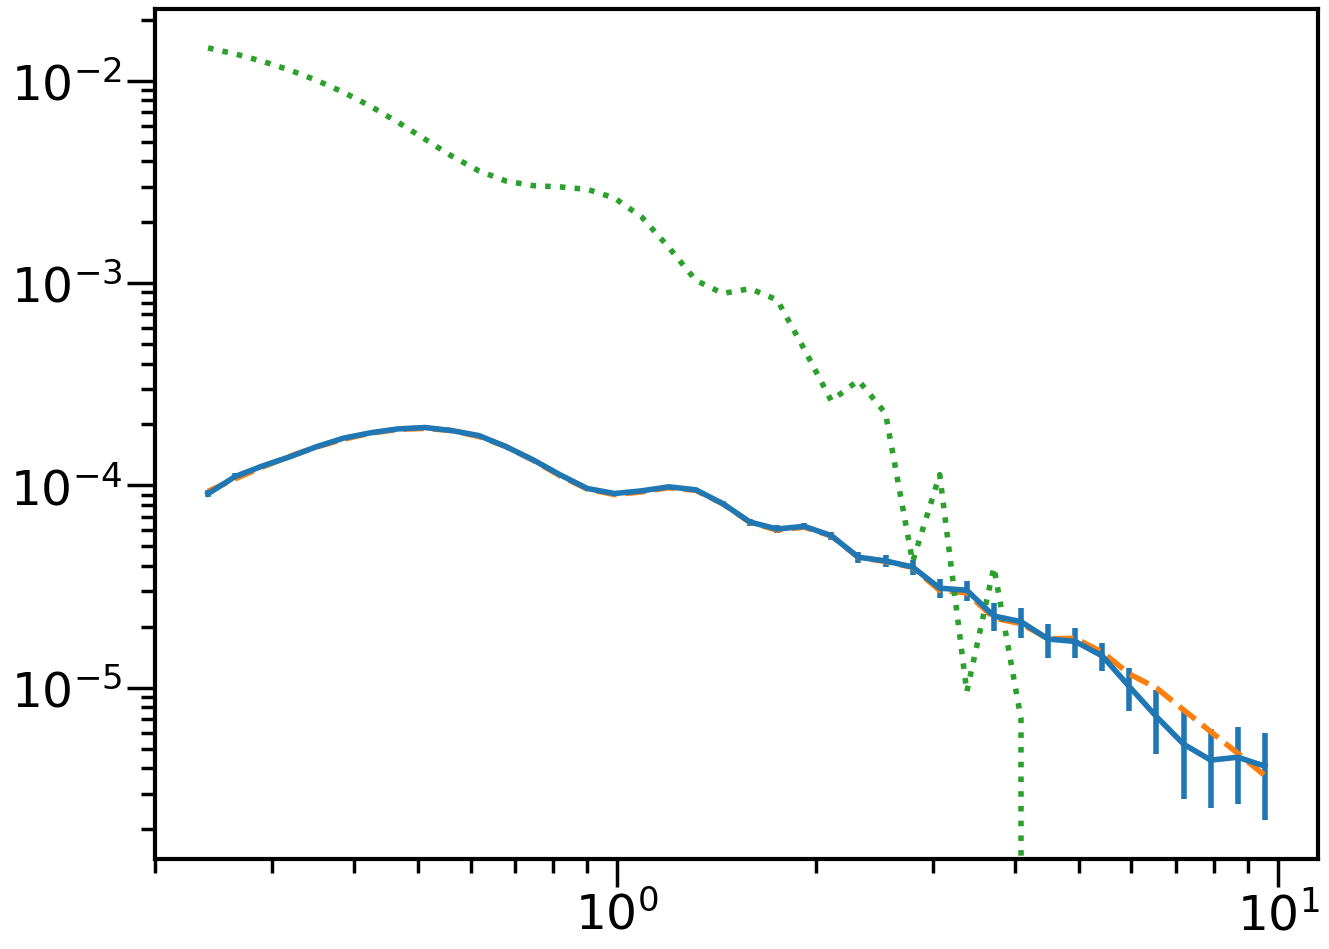

In [32]:
i=2
errorbar(cl_simi['thb'],cl_simi['xi_b_stats']['mean'].reshape(4,40)[i],cl_simi['xi_b_stats']['std'].reshape(4,40)[i])
plot(cl_simi['thb'],cl_simi['xi0']['xi'].reshape(4,40)[i],'--')
plot(cl_simi['thb'],cl_simi['wig_d_binned']['wig_d_binned'][corr_gg]@cl_simi['cl0_b'][corr_gg],':')
xscale('log')
yscale('log')

('shear', 'shear') 1
saved to  ./figures//xi0_cl0_sims_newN10_ns512_lmax512_wlmax1025_fsky03_noSN_deltaW_ll.pdf


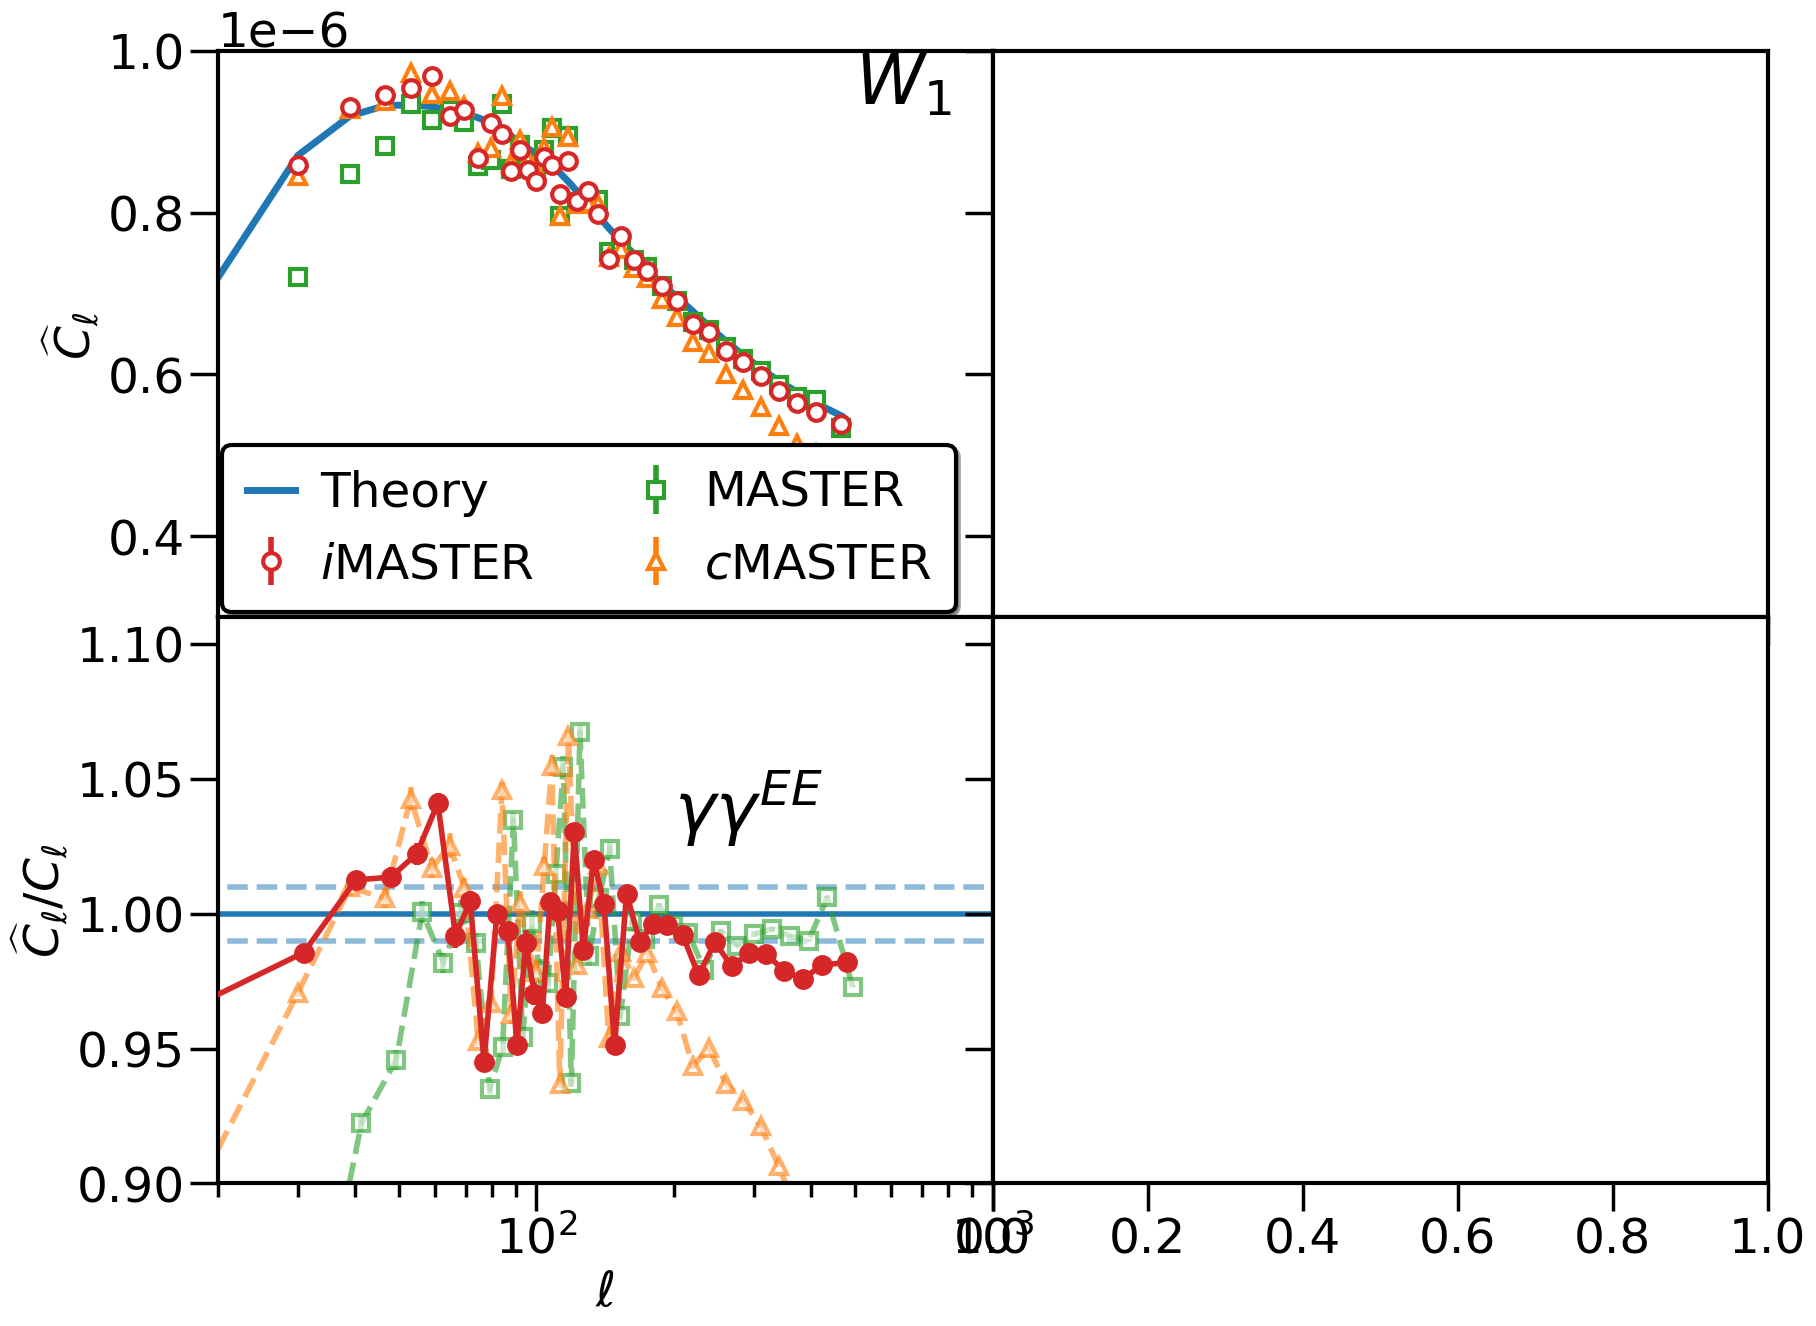

('galaxy', 'shear') 1
saved to  ./figures//xi0_cl0_sims_newN10_ns512_lmax512_wlmax1025_fsky03_noSN_deltaW_ggl.pdf


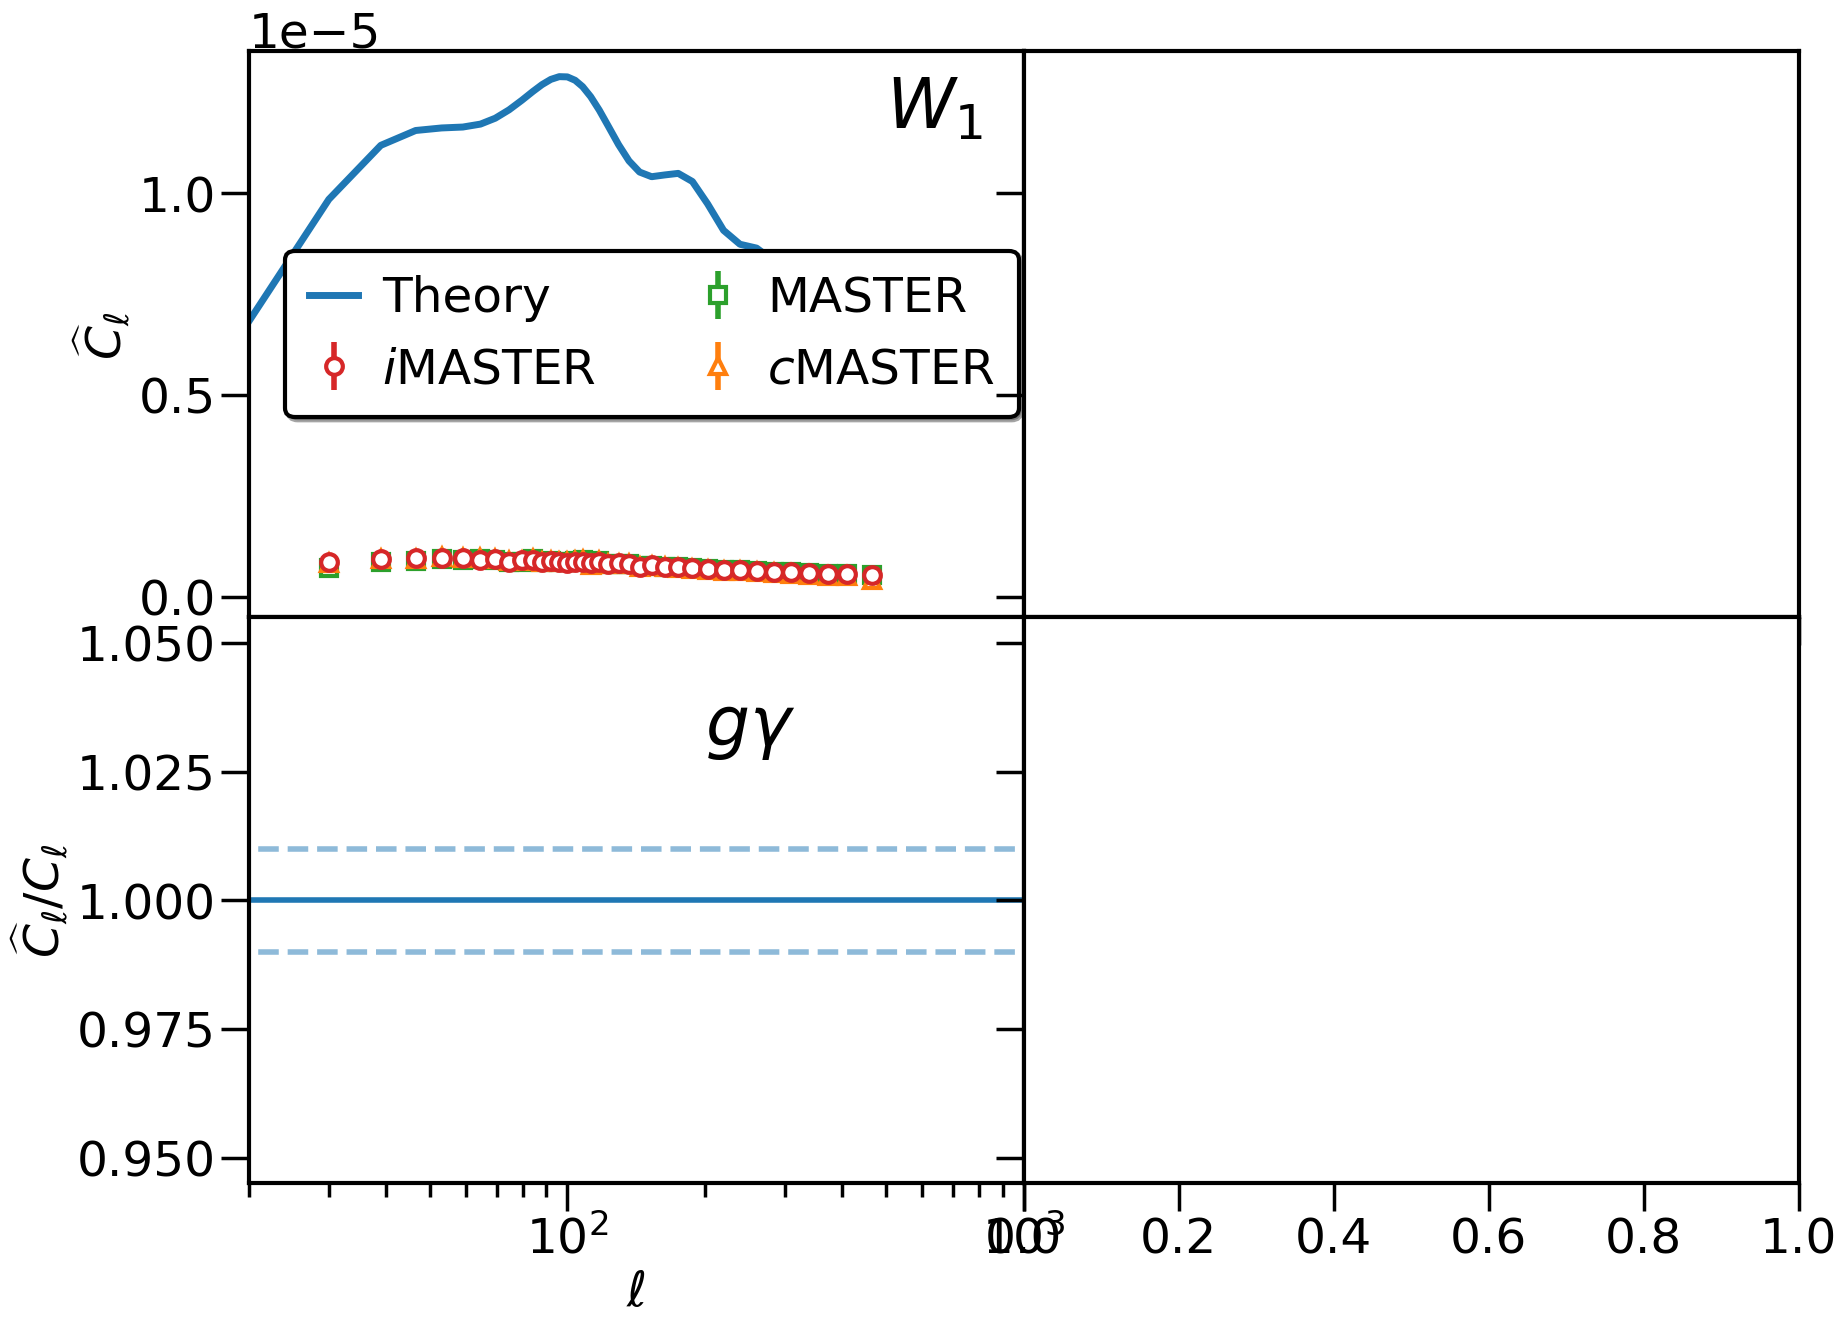

('galaxy', 'galaxy') 1
saved to  ./figures//xi0_cl0_sims_newN10_ns512_lmax512_wlmax1025_fsky03_noSN_deltaW_gg.pdf


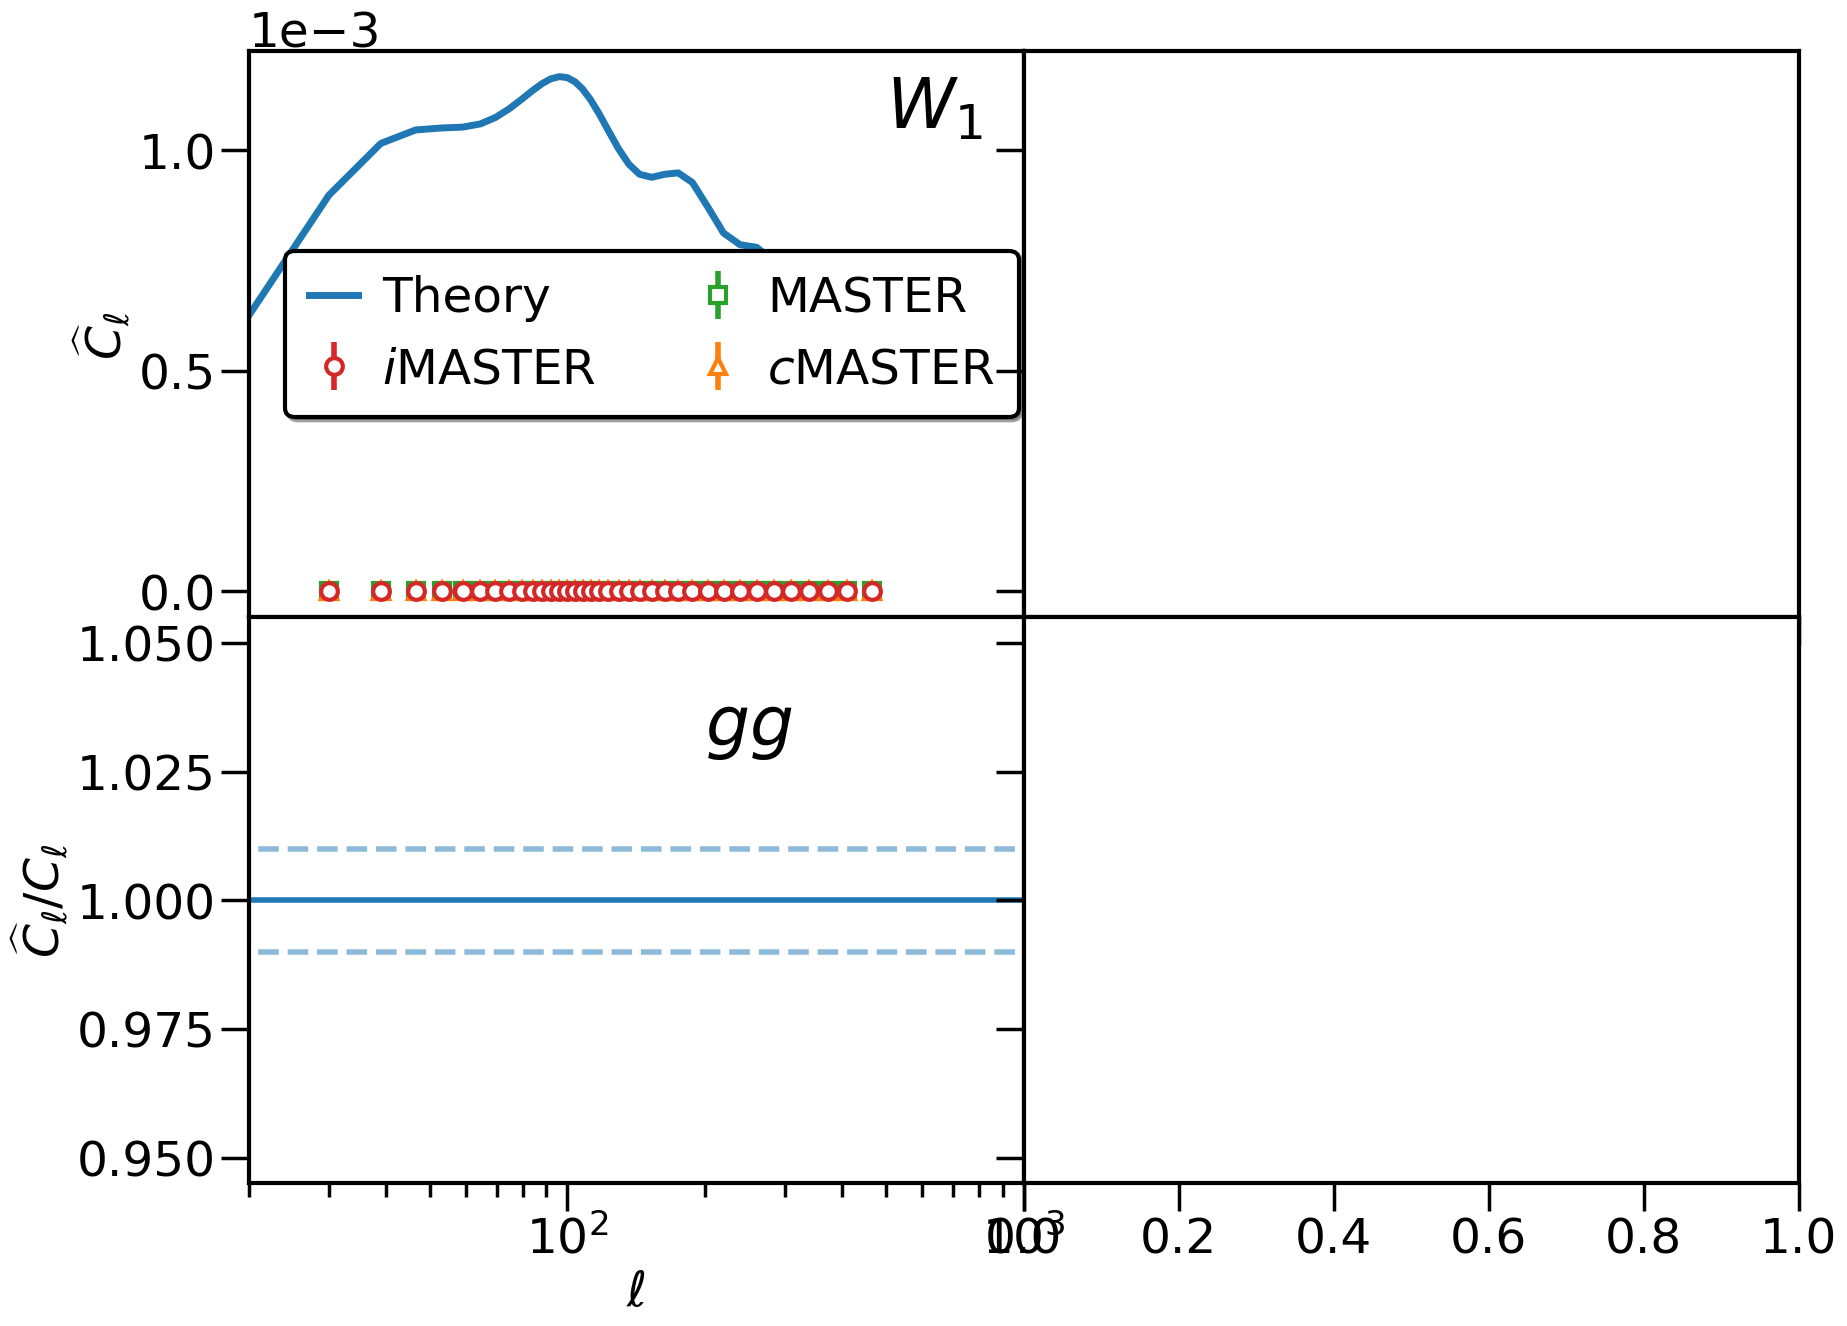

In [33]:
f=1
corr_i=0
for corr in [corr_ll,corr_ll,corr_ggl,corr_gg]:
    if corr_i==0:
        corr_i+=1
        continue
    fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
    color=colors[corr_i]
    marker=markers[corr_i]
    print(corr,corr_i)
    for simj in fnames.keys():#np.arange(1):
        cl_simi=cl_sim_W[simj]
        
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        nlb=len(lb)
        cl0i=cl_simi['cl0_b'][corr]#[nlb*corr_i:nlb*corr_i+nlb]
#         cl0i=cl_simi['cl0_b'][nlb*corr_i:nlb*corr_i+nlb]
        
        pS.plot(lb,f*cl0i,c=colors[0],label='Theory',lw=5)
        pS.errorbar(lb,f*cl_simi['cl_b_stats']['iMaster']['mean'].reshape(4,nlb)[corr_i],
                    f2*cl_simi['cl_b_stats']['iMaster']['std'].reshape(4,nlb)[corr_i],
                    fmt='o',c=colors[3],mfc='white',mew=3,label=r'$\it i$MASTER',zorder=10)    
        pS.errorbar(lb*1.0,f*cl_simi['cl_b_stats']['Master']['mean'].reshape(4,nlb)[corr_i],
                    f2*cl_simi['cl_b_stats']['Master']['std'].reshape(4,nlb)[corr_i],
                    fmt='s',c=colors[2],mfc='white',mew=3,label=r'MASTER')
        pS.errorbar(lb,f*cl_simi['cl_b_stats']['nMaster']['mean'].reshape(4,nlb)[corr_i],
                    f2*cl_simi['cl_b_stats']['nMaster']['std'].reshape(4,nlb)[corr_i],
                    fmt='^',c=colors[1],mfc='white',mew=3,label=r'$\it c$MASTER')

        f=1./cl0i
        f2=f/sqrt(nsim)
        pR.errorbar(lb*1.03,f*cl_simi['cl_b_stats']['iMaster']['mean'].reshape(4,nlb)[corr_i],
                    f2*cl_simi['cl_b_stats']['iMaster']['std'].reshape(4,nlb)[corr_i],
                    fmt='o-',c=colors[3],mfc=None,mew=3,label=r'$\it i$MASTER',zorder=10)
        pR.errorbar(lb*1.06,f*cl_simi['cl_b_stats']['Master']['mean'].reshape(4,nlb)[corr_i],
                    f2*cl_simi['cl_b_stats']['Master']['std'].reshape(4,nlb)[corr_i],
                    fmt='s--',c=colors[2],mfc='white',mew=3,label=r'MASTER',alpha=0.6)
        pR.errorbar(lb,f*cl_simi['cl_b_stats']['nMaster']['mean'].reshape(4,nlb)[corr_i],
                    f2*cl_simi['cl_b_stats']['nMaster']['std'].reshape(4,nlb)[corr_i],
                    fmt='^--',c=colors[1],mfc='white',mew=3,label=r'$\it c$MASTER',alpha=0.6)

        # plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
        # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
        pR.set_xscale('log')
        # yscale('log')
        pR.set_ylim(.945,1.055)
        pR.hlines(1,10,3000)
        pR.hlines(1.01,10,3000,ls='--',alpha=0.5,zorder=-1)
        pR.hlines(.99,10,3000,ls='--',alpha=0.5,zorder=-1)
        
#         pS.set_ylim((lb*cl0i).min()*.9,(lb*cl0i).max()*1.1)
        tf=.9
        if corr==corr_ll:
            pS.set_ylim(3.e-7,1.e-6)
            pR.set_ylim(.9,1.11)
            tf=1
        pR.set_xlim(20,1000)
        pR.set_xlabel(r'$\ell$')
        if simj==0:
            pR.set_ylabel(r'$\widehat C_\ell/C_\ell$')
            pS.set_ylabel(r'$\widehat C_\ell$ ')#+corr_labels[corr])
        pS.text(x=500,y=(lb*cl0i).max()*tf,s=r'$W_'+str(simj+1)+'$',fontsize=50)
    ax[0,0].legend(ncol=2)
    ax[1,0].text(x=200,y=1.03,s=corr_labels[corr],fontsize=50)
    
    fname=fnames[0].split('.pkl')[0]
    fname=fname.split('tests')[1]
    fname=fname.split('.')
    fname=fname[0]+fname[1]

    fname=fig_home+fname
    fname+='_'+corr_fnames[corr]+'.pdf'
#     fig.savefig(fname,bbox_inches='tight',format='pdf')
    print('saved to ',fname)
    show()

('shear', 'shear') 0
('galaxy', 'shear') 2
('galaxy', 'galaxy') 3


[]

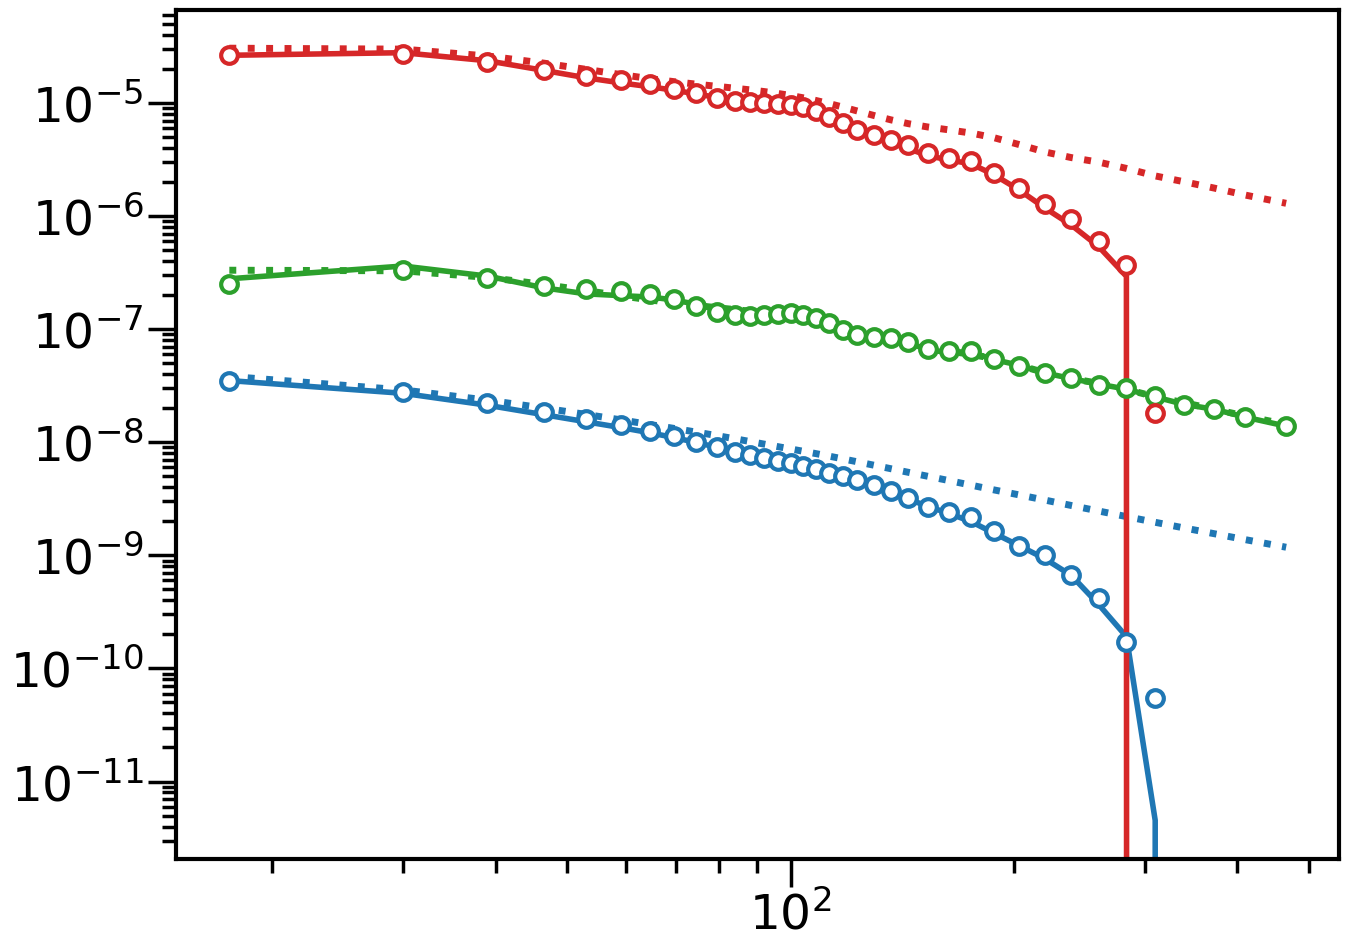

In [42]:
f=1
corr_i=0
for corr in [corr_ll,corr_ll,corr_ggl,corr_gg]:
    if corr_i==1 and corr==corr_ll:
        corr_i+=1
        continue
    color=colors[corr_i]
    marker=markers[corr_i]
    print(corr,corr_i)
    for simj in fnames.keys():#np.arange(1):
        cl_simi=cl_sim_W[simj]
        
        f=1#lb
        f2=f/sqrt(nsim)
        i=0
        nlb=len(lb)
        cl0i=cl_simi['cl0_b'][corr]
#         cl0i=cl_simi['cl0_b'][nlb*corr_i:nlb*corr_i+nlb]
        
        plot(lb,f*cl0i,c=colors[corr_i],label='Theory',lw=5,ls=':')
        wgd=cl_simi['wig_d_binned']['wig_d_binned'][corr]
#         wgdi=np.linalg.pinv(wgd)
        plot(lb,cl_simi['wig_d_binned']['wig_d_binned_inv'][corr]@cl_simi['xiW0']['xi'].reshape(4,40)[corr_i],c=colors[corr_i])
#         plot(lb,f*(wgdi@cl_simi['xi0']['xi'].reshape(4,40)[corr_i]))
        errorbar(lb,f*cl_simi['cl_b_stats']['xi_imaster']['mean'].reshape(4,nlb)[corr_i],
                    f2*cl_simi['cl_b_stats']['xi_imaster']['std'].reshape(4,nlb)[corr_i],
                    fmt='o',c=colors[corr_i],mfc='white',mew=3,label=r'$\it i$MASTER',zorder=10)
        corr_i+=1
loglog()

('shear', 'shear') 0
('galaxy', 'shear') 2
('galaxy', 'galaxy') 3


[]

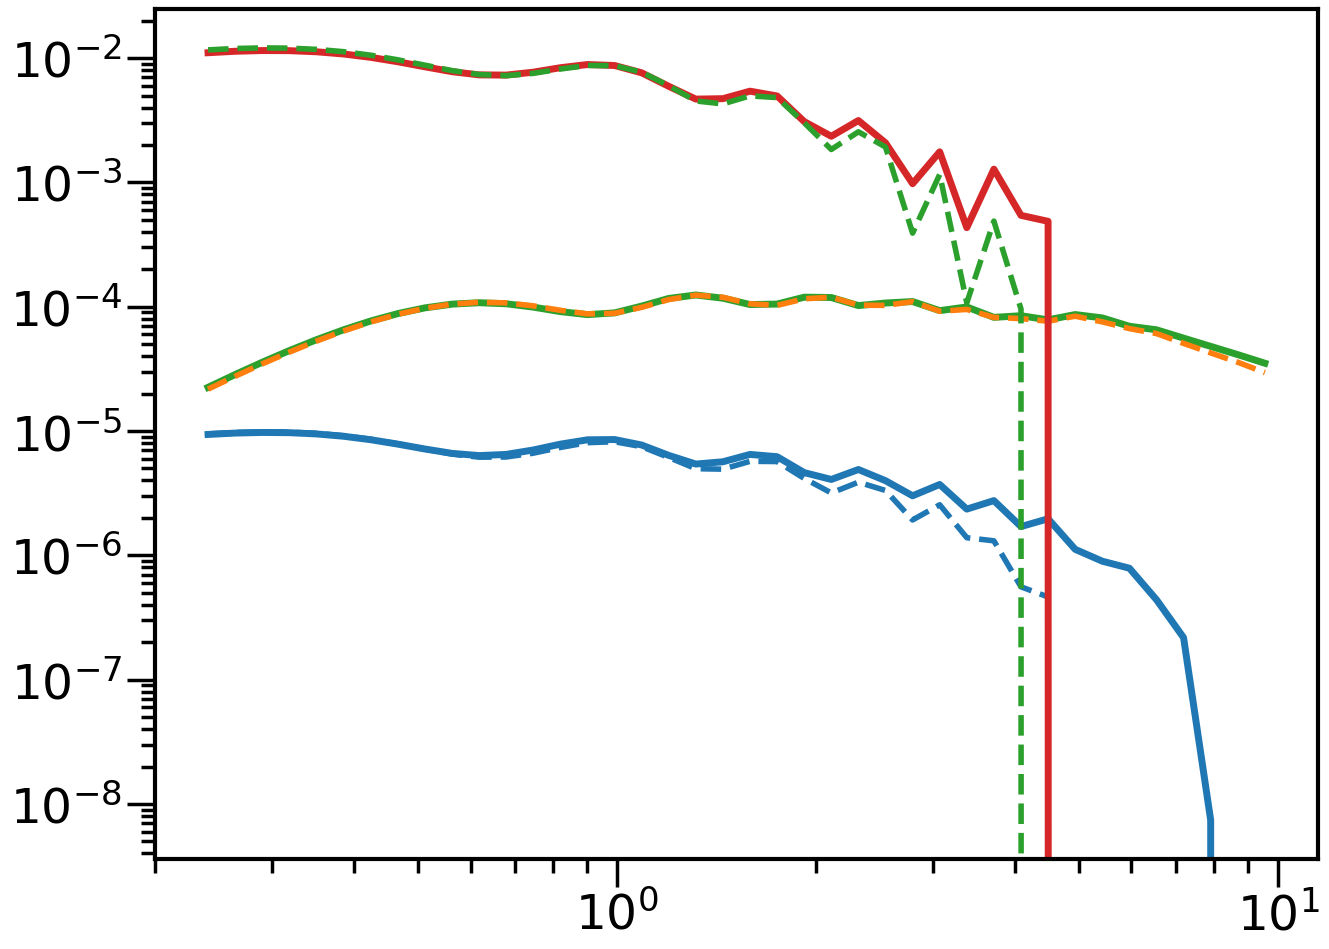

In [35]:
f=1
corr_i=0
for corr in [corr_ll,corr_ll,corr_ggl,corr_gg]:
    if corr_i==1 and corr==corr_ll:
        corr_i+=1
        continue
    color=colors[corr_i]
    marker=markers[corr_i]
    print(corr,corr_i)
    for simj in fnames.keys():#np.arange(1):
        cl_simi=cl_sim_W[simj]
        thb=cl_simi['thb']
        f=thb
        f2=f/sqrt(nsim)
        i=0
        xi0i=cl_simi['xi0']['xi'].reshape(4,40)[corr_i]
        
        plot(thb,f*xi0i,c=colors[corr_i],label='Theory',lw=5)
        wgd=cl_simi['wig_d_binned']['wig_d_binned'][corr]
        wgdi=np.linalg.pinv(wgd)
        plot(thb,f*(wgd@cl_simi['cl0_b'][corr])/.3,'--')
        corr_i+=1
loglog()

In [ ]:
wgd@wgdi

In [ ]:
cl_simi=cl_sim_W[1]
coupling_M_N=cl_simi['coupling_M']['full']['coupling_M_N']['shear_B']
coupling_M_N0=cl_simi['coupling_M']['full']['coupling_M_N'][corr_ll]

In [ ]:
crash

In [ ]:
pcolor(coupling_M_N,norm=LogNorm())

In [ ]:
corr_i=0
f=lb
errorbar(lb,cl_simi['pcl_b_stats']['mean'].reshape(4,36)[corr_i],cl_simi['pcl_b_stats']['std'].reshape(4,36)[corr_i],
            fmt=marker,c=color,label=corr_labels[corr])
plot(l,cl_simi['pclN0']['shear_B'],c=colors[5])
# plot(l,(coupling_M_N@cl_simi['clN0_0']['shear_B']))
plot(l,cl_simi['clN0_0']['shear_B']@coupling_M_N)
plot(l,cl_simi['clN0_0']['shear_B']@coupling_M_N0)
xscale('log')
yscale('log')

In [ ]:
cl_simi['clN0_0']['shear_B']@coupling_M_N

In [ ]:
cl_simi=cl_sim_W[0]
nside=cl_simi['nside']
lmax_cl=cl_simi['l'].max()
window_lmax=cl_simi['window_l'].max()
Nl_bins=len(cl_simi['l_bins'])-1
l0w=np.arange(3*nside-1)
lmax_cl,window_lmax,Nl_bins

In [ ]:
l0=cl_simi['l']
l=l0
l_bins=cl_simi['l_bins']
lb=(l_bins[1:]+l_bins[:-1])*.5

In [ ]:
do_cov=True
bin_cl=True

SSV_cov=False
tidal_SSV_cov=False

do_xi=False

use_window=True
f_sky=0.3
n_source_bins=1
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [ ]:
store_win=True
unit_window=False
smooth_window=False

In [ ]:
do_cov=True
store_win=True

In [ ]:
wigner_files={}
home='/verafs/scratch/phy200040p/sukhdeep/physics2/skylens/'
wig_home=home+'temp/'
wigner_files[0]= wig_home+'/dask_wig3j_l1100_w2200_0_reorder.zarr'
# wigner_files[0]= wig_home+'/dask_wig3j_l3500_w2100_0_reorder.zarr'
wigner_files[2]= wig_home+'/dask_wig3j_l3500_w2100_2_reorder.zarr'


In [ ]:
corrs=[corr_gg]#,corr_ggl,corr_gg]

In [ ]:
bi=(0,0)
use_binned_l=False

In [ ]:
kappa_win={}

In [ ]:
skylens_kwargs[0].keys()

In [ ]:
skylens_kwargs[0]['scheduler_info']=None
skylens_kwargs2=copy.deepcopy(skylens_kwargs[0])

In [ ]:
skylens_kwargs2['corrs']

In [ ]:
skylens_kwargs2['corrs']=corrs

In [ ]:
tracemalloc.clear_traces()
tracemalloc.start()


t1=time.time()
for i in [0]:#zs_bin.keys():
    kappa_win[i]=Skylens(**skylens_kwargs2)
#     kappa_win[i]=Skylens(shear_zbins=zs_bin[i],do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin[i],
#             use_window=use_window,store_win=store_win,window_lmax=window_lmax,corrs=corrs,
#             SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
#             WT=None,do_xi=do_xi,wigner_files=wigner_files,use_binned_l=False,
#             nz_PS=100,
# #                  Win=kappa_win.Win.Win
#                  )
    kappa_win[i].gather_data()
#     client.restart()
    t2=time.time()
    print('W done',t2-t1)

# kappa_win_binned=Skylens(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
#             use_window=use_window,store_win=store_win,window_lmax=window_lmax,corrs=corrs,
#             SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
#             WT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,
#                   wigner_files=wigner_files,use_binned_l=True,
# #                  Win=kappa_win.Win.Win
#                  )



In [ ]:
clG_win={}
cl0_win={}
for i in kappa_win.keys():
    %time clG_win[i]=kappa_win[i].cl_tomo(corrs=corrs) 
    %time cl0_win[i]=clG_win[i]['stack'].compute()

# if do_xi:
#     %time xiWG_L=kappa_win.xi_tomo()
#     %time xiW_L=xiWG_L['stack'].compute()

In [ ]:
kappa0=Skylens(shear_zbins=zs_bin[0],do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin[0],
            use_window=False,store_win=store_win,corrs=corrs,window_lmax=window_lmax,
            SSV_cov=True,tidal_SSV_cov=True,f_sky=f_sky,use_binned_l=False,
            do_xi=do_xi)

%time clG0=kappa0.cl_tomo(corrs=corrs) 
%time cl0=clG0['stack'].compute()

if do_xi:
    %time xiG_L0=kappa0.xi_tomo()
    %time xi_L0=xiG_L0['stack'].compute()

In [ ]:
bi=(0,0)
cl0={'cl_b':{},'cov':{},'cl':{}}

for corr in corrs:
    cl0['cl_b'][corr]=clG0['cl_b'][corr][bi].compute()
    cl0['cl'][corr]=clG0['cl'][corr][bi].compute()
    cl0['cov'][corr]=clG0['cov'][corr+corr][bi+bi].compute()
    
   
    
#     cl0_win_w['cl_b'][corr]=clG_win_w['pseudo_cl_b'][corr][bi].compute()
#     cl0_win_w['cov'][corr]=clG_win_w['cov'][corr+corr][bi+bi].compute()['final_b']

In [ ]:
cl0_win={}
for i in zs_bin.keys():
    cl0_win[i]={'cl_b':{},'pcl_b':{},'cov':{},'cl':{}}
    for corr in corrs:
        cl0_win[i]['pcl_b'][corr]=clG_win[i]['pseudo_cl_b'][corr][bi].compute()
        cl0_win[i]['cl_b'][corr]=clG_win[i]['cl_b'][corr][bi].compute()
        cl0_win[i]['cl'][corr]=clG_win[i]['cl'][corr][bi].compute()
        cl0_win[i]['cov'][corr]=clG_win[i]['cov'][corr+corr][bi+bi].compute()['final_b']

In [ ]:
kappa_win[0].gather_data()

In [ ]:
kappa_win[0].Win0.Win['cl'][corr_ll][bi]['s1s2']

In [ ]:
i=0
cl_simi=cl_sim_W[i]
f=lb
corr_i=1
corr=corr_ll
errorbar(lb,f*cl_simi['pcl_b_stats']['mean'].reshape(4,36)[corr_i],f*cl_simi['pcl_b_stats']['std'].reshape(4,36)[corr_i],
         fmt=marker,c=color,label=corr_labels[corr])
# plot(lb,f*cl0_win[i]['cl_b'][corr])
# plot(l,l*cl0_win[i]['cl'][corr])
plot(l,l*(cl0_win[i]['cl'][corr]@kappa_win[0].Win['cl'][corr][bi]['M']),'--')
plot(lb,f*cl0_win[i]['pcl_b'][corr],'--')
plot(lb,f*cl_simi['pcl0'][corr],c=color)
plot(lb,f*cl0_win0[0]['cl_b'][corr]*.99)
xscale('log')

In [ ]:
i=0
cl_simi=cl_sim_W[i]
f=1
corr_i=1
corr=corr_ll
errorbar(lb,f*cl_simi['pcl_b_stats']['mean'].reshape(4,36)[corr_i],f*cl_simi['pcl_b_stats']['std'].reshape(4,36)[corr_i],
         fmt=marker,c=color,label=corr_labels[corr])
# plot(lb,f*cl0_win[i]['cl_b'][corr])
# plot(l,l*cl0_win[i]['cl'][corr])
plot(l,(cl0_win[i]['cl'][corr]@kappa_win[0].Win['cl'][corr][bi]['M']),'--')
plot(lb,cl0_win[i]['pcl_b'][corr],'--')
plot(lb,cl_simi['pcl0'][corr],c=color)
plot(lb,cl0_win0[0]['cl_b'][corr]*.99)
xscale('log')

In [ ]:
wl=hp.anafast(zs_bin[0][0]['window'])[kappa_win[0].window_l]
wlN=hp.anafast(zs_bin[0][0]['window_N'])[kappa_win[0].window_l]

In [ ]:
plot(kappa_win[0].window_l,wl)
plot(kappa_win[0].window_l,wlN)
loglog()

In [ ]:
hp.mollview(zs_bin[0][0]['window'],title='W1')

In [ ]:
hp.mollview(zs_bin[1][0]['window'],title='W2')

In [ ]:
hp.mollview(zs_bin[0][0]['window_N'])

In [ ]:
wn=zs_bin[0][0]['window_N']*1.
x=zs_bin[0][0]['window_N']!=hp.UNSEEN
wn[~x]=0
zs_bin[0][0]['window_N'][x].mean(),wn.mean(),x.mean()

In [ ]:
(zs_bin[0][0]['window_N'][x]**2).mean(),((wn)**2).mean()

In [ ]:
client

In [ ]:
corr

In [ ]:
l2=l #np.arange(1050)

In [ ]:
win_class=window_utils(window_l=kappa_win[0].window_l,l=l2,corrs=kappa_win[0].corrs,use_window=True,
                       wigner_files=wigner_files,corr_indxs=kappa_win[0].corr_indxs,wigner_step=2100,
                      s1_s2s={corr:(2,2)})
win_class.set_wig3j()
wigj2=client.compute(win_class.wig_3j_2).result()
mf2=client.compute(win_class.mf_pm).result()

In [ ]:
M2=(wigj2[0]['22']*(1-mf2[0]['mf_p']))@(wlN*(2*win_class.window_l+1))
# M2=(wigj2[0]['22'])@(wl*(2*win_class.window_l+1))
M2/=4*np.pi
M2*=win_class.MF

In [ ]:
M2N=M2

In [ ]:
pcolor(M2N,norm=LogNorm(),cmap='Reds')
colorbar()

In [ ]:
cl_simi['coupling_M']['full'].keys()

In [ ]:
cl_simi=cl_sim_W[0]
coupling_M_N=cl_simi['coupling_M']['full']['coupling_M_N']['shear_B']
coupling_M_B=cl_simi['coupling_M']['full']['coupling_M_binned']['iMaster']['shear_B']

In [ ]:
plot(np.diag(coupling_M_N))
plot(np.diag(M2N))
xscale('log')

In [ ]:
corr=corr_ll

In [ ]:
M2.shape

In [ ]:
plot(l,(np.ones_like(l)@coupling_M_N))
plot(l2,(np.ones_like(l2)@M2),'--')
xscale('log')
yscale('log')

In [ ]:
corr=corr_ll

In [ ]:
cl_simi.keys()

In [ ]:
cl_simi['cl0_b']

In [ ]:
i=0
cl_simi=cl_sim_W[i]
f=1# lb
corr_i=0
corr=corr_ll
errorbar(lb,f*cl_simi['pcl_b_stats']['mean'].reshape(4,36)[corr_i],f*cl_simi['pcl_b_stats']['std'].reshape(4,36)[corr_i],
         fmt=marker,c=color,label=corr_labels[corr])
plot(lb,(cl0['cl_b'][corr]@coupling_M_B))

# plot(lb,f*cl0_win[i]['cl_b'][corr])
# plot(l,l*cl0_win[i]['cl'][corr])
# plot(l,(cl0_win[i]['cl'][corr]@kappa_win[0].Win['cl'][corr][bi]['M']))
# plot(l,(zs_bin[0]['SN']['galaxy'][0,0]*np.ones_like(l))@M2N+(cl0_win[i]['cl'][corr]@kappa_win[0].Win['cl'][corr][bi]['M']),':')
# plot(l,(zs_bin[0]['SN']['shear'][0,0]*np.ones_like(l))@M2N,':')
# plot(l,(98*2.*zs_bin[0]['SN']['galaxy'][0,0]*np.ones_like(l))+(cl0_win[i]['cl'][corr]@kappa_win[0].Win['cl'][corr][bi]['M']),':')
# plot(lb,f*cl0_win[i]['pcl_b'][corr])
xscale('log')

In [ ]:
cl0_win[0].keys()

In [ ]:
mm=hp.synfast(zs_bin[0]['SN']['galaxy'][0,0]*np.ones(6200),nside=1024)
ww=1+hp.synfast(cl0_win[0]['cl'][corr],nside=1024)
mm2=mm*ww#zs_bin[0][0]['window_N']
x=zs_bin[0][0]['window_N']!=hp.UNSEEN
mm2[~x]=hp.UNSEEN
mm[~x]=hp.UNSEEN
x.mean()

In [ ]:
m2cl=hp.anafast(mm2)[kappa_win[0].window_l]
mcl=hp.anafast(mm)[kappa_win[0].window_l]

In [ ]:
pw=hp.sphtfunc.pixwin(nside=1024)[kappa_win[0].window_l]

In [ ]:
(m2cl/zs_bin[0]['SN']['galaxy'][0,0]).mean(),(mcl/zs_bin[0]['SN']['galaxy'][0,0]).mean()

In [ ]:
plot(kappa_win[0].window_l,m2cl/zs_bin[0]['SN']['galaxy'][0,0])
plot(kappa_win[0].window_l,mcl/zs_bin[0]['SN']['galaxy'][0,0])
plot(l,(np.ones_like(l))@M2N,'--')
plot(l,80*(np.ones_like(l)))
plot(l,.3*(np.ones_like(l)))
loglog()

In [ ]:
# plot(l,np.ones_like(l)@kappa_win[0].Win['cl'][corr][bi]['M_noise'])
# plot(l,np.ones_like(l)@cl_sim_W[0]['coupling_M']['full']['coupling_M_N'][corr],'--')
plot(l,(zs_bin[0]['SN']['galaxy'][0,0]*np.ones_like(l))@M2N,':')
cl_sim_W
# plot(l,l*(cl0_win[i]['cl'][corr]@M2),'--')
xscale('log')
yscale('log')

In [ ]:
win_class.wig_3j_2

In [ ]:
plot(kappa_win[0].window_l,wl)
loglog()

In [ ]:
f=1
corr_i=0
fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
for corr in [corr_ll,corr_ll,corr_ggl,corr_gg]:
    color=colors[corr_i]
    marker=markers[corr_i]
    print(corr,corr_i)
    for simj in np.arange(2):
        cl_simi=cl_sim_W[simj]
#         else:
#             cl_simi=cl_sim_Ww
        l_bins=cl_simi['l_bins']
        lb=0.5*(l_bins[1:]+l_bins[:-1])
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        pS.errorbar(lb,f*cl_simi['pcl_b_stats']['mean'].reshape(4,36)[corr_i],f*cl_simi['pcl_b_stats']['std'].reshape(4,36)[corr_i],fmt=marker,c=color,label=corr_labels[corr])
        if corr==corr_ll and corr_i==0:
            pass
#             pS.plot(lb,f*cl_simi['pcl_shear_B_b'],c=colors[5])
        else:
            pS.plot(lb,f*cl_simi['pcl0'][corr],c=color)

        f=1./cl_simi['pcl0'][corr]
        f2=f/sqrt(nsim)
        pR.errorbar(lb*1.0,f*cl_simi['pcl_b_stats']['mean'].reshape(4,36)[corr_i],
                    f2*cl_simi['pcl_b_stats']['std'].reshape(4,36)[corr_i],fmt=marker+'-',c=color,mfc=None,mew=3,zorder=10)

        pR.set_xscale('log')
        # yscale('log')
        pR.set_ylim(.95,1.08)
        pR.hlines(1,10,3000)
        pR.hlines(1.01,10,3000,ls='--',alpha=0.5,zorder=-1)
        pR.hlines(.99,10,3000,ls='--',alpha=0.5,zorder=-1)
        
        pS.set_yscale('log')
#         pS.set_ylim(1.e-10,8.e-4)
#         tf=.9
#         if corr==corr_ll:
#             pS.set_ylim(3.e-7,1.e-6)
#             pR.set_ylim(.9,1.11)
#             tf=1
        pR.set_xlim(20,1050)
        pR.set_xlabel(r'$\ell$')
        if simj==0:
            pR.set_ylabel(r'$\widehat D_\ell/D_\ell$')
            pS.set_ylabel(r'$\widehat D_\ell$ ')
        if corr==corr_ll:
            if simj==0:
                pS.text(x=200,y=1.e-5,s=r'$W_'+str(simj+1)+'$',fontsize=50)
            if simj==1:
                pS.text(x=200,y=1.e-5,s=r'$W_'+str(simj+1)+'$',fontsize=50)
    corr_i+=1
ax[0,1].legend(ncol=4,loc='lower left',bbox_to_anchor=(-.07,0))
ax[0,0].set_yticks(np.logspace(-10,-4,7))
# # fname=fig_home+'/'+corr_fnames[corr]+'_pseudo_cl_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
# if not use_shot_noise:
#     fname+='_noSN'
# if unit_window:
#     fname+='_unit_window'
# if smooth_window:
#     fname+='_smooth_window'


# fname+='.pdf'
# fig.savefig(fname,bbox_inches='tight',format='pdf')
# print('saved to ',fname)    
show()

In [ ]:
cm=hp.synfast(cl_simi['cl0'][0],nside=512)
cm2=cm*1.
cm2[int(len(cm)/5):]=hp.UNSEEN
cc=hp.anafast(cm)
cc2=hp.anafast(cm2)

In [ ]:
plot(cc)
plot(cc2,'--')
loglog()

In [ ]:
cl_simi['pcl0'][corr_ll]

In [ ]:
corr_i=0
for corr in [corr_ll,corr_ll,corr_ggl,corr_gg]:
    color=colors[corr_i]
    if corr_i==0:
        corr_i+=1
        continue
    plot(lb,cl_simi['pcl_b_stats']['mean'].reshape(4,36)[corr_i],c=color)
#     plot(lb,cl_simi['cl_b_stats']['iMaster']['mean'].reshape(4,36)[corr_i],c=color,ls='--')
    plot(lb,cl_simi['pcl0'][corr],c=color,ls='--')
#     plot(lb,cl0_win[0]['cl_b'][corr],c=color)
    plot(cl_simi['l'],cl_simi['cl0'][corr_i-1],':')
    corr_i+=1
# plot(cl_simi['l'],cl_simi['cl0'][corr_i-1],':')
loglog()

In [ ]:
plot(lb,cl0_win[0]['cl_b'][corr])
plot(lb,cl_simi['pcl0'][corr]*.3,'--')
loglog()

In [ ]:
corr=corr_ll
f=lb
color=colors[0]
f2=f/np.sqrt(10)
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    cl0_wini=cl0_win[simj]
    cl0i=cl0[simj]
    errorbar(lb,f*cl_simi['clp_b_stats'][corr]['mean'],f2*cl_simi['clp_b_stats'][corr]['std'],fmt='o',c=color)
    #     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
    plot(lb,f*cl0_wini['cl_b'][corr],label=labels[corr],c=color)
    # plot(lb,f*cl_sim_W['clp0'][corr],c=color)
    if corr==corr_ll:
        errorbar(lb*1.03,f*cl_simi['clpB_b_stats'][corr_gg]['mean'],f2*cl_simi['clpB_b_stats'][corr_gg]['std'],fmt='^',c=color)
        plot(lb*1.03,f*cl_simi['clp_shear_B_b'],label=labels[corr]+'-BB',c=color)


    xscale('log')
    yscale('log')
    # ylim(5.e-10,1.e-7)
    xlim(10,1000)
    show()
    corr=corr_ll
    f=lb
    errorbar(lb,f*cl_simi['cl_b_stats']['iMaster'][corr]['mean'],f2*cl_simi['cl_b_stats']['iMaster'][corr]['std'],fmt='o',c=color)
    #     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
    plot(lb,f*cl0i['cl_b'][corr],label=labels[corr],c=color)
    if corr==corr_ll:
    #     f=0
        errorbar(lb*1.03,f*cl_simi['clgB_b_stats']['iMaster'][corr_ll]['mean'],f2*cl_simi['clgB_b_stats']['iMaster'][corr_ll]['std'],fmt='^',c=color)
    #     plot(lb,f*cl_sim_Ww_test['clp_shear_B_b'],label=labels[corr]+'-BB',c=color)

    xscale('log')
    # yscale('log')
    xlim(10,1000)

    show()

In [ ]:
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    corr_m=corr_matrix(cl_simi['clp_b_stats'][corr_ll]['cov'])
    pcolor(lb,lb,corr_m,vmin=-1,vmax=1,cmap='seismic')
    loglog()
    show()

In [ ]:
corr=corr_ll
bi=(0,0)

In [ ]:
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    cov_t=cl_simi['clpB_b_stats'][corr_gg]['cov']
    SN2B=cl_simi['clpB_b_stats'][corr_gg]['mean']@np.linalg.inv(cov_t)@cl_simi['clpB_b_stats'][corr_gg]['mean']
    cov_t=cl_simi['clp_b_stats'][corr_ll]['cov']
    SN2=cl_simi['clp_b_stats'][corr_ll]['mean']@np.linalg.inv(cov_t)@cl_simi['clp_b_stats'][corr_ll]['mean']
    print(np.sqrt(SN2),np.sqrt(SN2B))

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    cl0_wini=cl0_win[simj]
    for corr in corrs:
        color=colors[i%len(colors)]
        errorbar(lb,f*cl_simi['clp_b_stats'][corr]['mean'],f*cl_simi['clp_b_stats'][corr]['std'],fmt='o',c=color)
    #     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
        plot(lb,f*cl0_wini['cl_b'][corr],label=labels[corr],c=color)
        if corr==corr_ll:
            errorbar(lb,f*cl_simi['clpB_b_stats'][corr_gg]['mean'],f*cl_simi['clpB_b_stats'][corr_gg]['std'],fmt='^',c=color)
            plot(lb,f*cl_simi['clp_shear_B_b'],label=labels[corr]+'-BB',c=color)

        i+=1
        # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
        xscale('log')
    #     yscale('log')
        xlabel(r'$\ell$')
        ylabel(r'$D_\ell$ (W1)')
        legend()
        if corr==corr_ll:
            ylim(.8e-9,1.e-6)
            yscale('log')
        xlim(10,nside)
        show()

In [ ]:
outp[0]['simW'].keys()

In [ ]:
outp[simj]['zs_bin1']['SN'].keys()

In [ ]:
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    cl0_wini=cl0_win[simj]
    cl0_wini=cl0_win[simj]#
    clt=cl0i['cl'][corr_ll]+outp[simj]['zs_bin1']['SN']['shear'][0,0]#kappa_win[simj].SN[corr_ll][0,0,0]
    corr=corr_gg
    # cl_shear_B=kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M'][corr_ll]+clt@cl_sim_W['coupling_M']['shear_B']
    # cl_shear_B_b=M_binnings[corr_ll].bin_1d(xi=cl_shear_B,bin_utils=M_binning_utils[corr_ll])
    errorbar(lb,cl_simi['clpB_b_stats'][corr]['mean']/cl_simi['clp_shear_B_b'],cl_simi['clpB_b_stats'][corr]['std']/cl_simi['clp_shear_B_b']/sqrt(nsim))
    # errorbar(lb,cl_sim_Ww['clpB_b_stats'][corr]['mean']/cl_sim_Ww['clp_shear_B_b'],cl_sim_Ww['clpB_b_stats'][corr]['std']/cl_sim_Ww['clp_shear_B_b']/sqrt(nsim))
    # plot(lb,cl_shear_B_b/cl_sim_W['clp_shear_B_b'])
    xscale('log')
    # yscale('log')
    # ylim(0.99,1.05)
    xlim(10,1000)
    hlines(1,10,2000)
    show()

In [ ]:
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    corr_m=corr_matrix(cl_simi['clpB_b_stats'][corr_ll]['cov'])
    pcolor(lb,lb,corr_m,vmin=-1,vmax=1,cmap='seismic')
    loglog()
    show()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1#lb
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    cl0_wini=cl0_win[simj]
    i=0
    for corr in corrs:
        color=colors[i%len(colors)]
    #     errorbar(lb*(1+i*0.03),cl_sim_W['clp_b_stats'][corr]['mean']/cl_sim_W['clp0'][corr],cl_sim_W['clp_b_stats'][corr]['std']/cl_sim_W['clp0'][corr]/30,
    #              fmt='o-',c=color,label=labels[corr])
        errorbar(lb*(1+i*0.03),cl_simi['clp_b_stats'][corr]['mean']/cl0_wini['cl_b'][corr],
                 cl_simi['clp_b_stats'][corr]['std']/cl0_wini['cl_b'][corr]/sqrt(nsim),
                 fmt='o-',c=color,label=labels[corr])
        i+=1
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
    # yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'$D_\ell$ (W1)')
    hlines(1,10,3000)
    hlines(1.01,10,3000,ls=':')
    hlines(.99,10,3000,ls=':')
    legend(ncol=3)
    ylim(0.95,1.05)
    xlim(10,nside*1)
    show()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    cl0_wini=cl0_win[simj]
    cl0i=cl0[simj]
    i=0
    for corr in corrs:
        color=colors[i%len(colors)]
        errorbar(lb*(1+i*0.03),f*cl_simi['cl_b_stats']['Master'][corr]['mean'],
                 f*cl_simi['cl_b_stats']['Master'][corr]['std'],fmt='o',c=color)
        plot(lb*(1+i*0.03),f*cl0i['cl_b'][corr],c=color,label=labels[corr])
        i+=1
    # plot(lb,f*cl0_win_w['cl_b'][:39])
    # plot(lb,f*cl0_win['cl_b'])
    # plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
    yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'$C_\ell$ (W1)')
    # xlim(10,1000)
    legend()
    ylim(1.e-10,1.e-4)
    show()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    cl0_wini=cl0_win[simj]
    cl0i=cl0[simj]
    i=0
    for corr in corrs:
        color=colors[i%len(colors)]
        errorbar(lb*(1+i*0.03),f*cl_simi['cl_b_stats']['iMaster'][corr]['mean'],
                 f*cl_simi['cl_b_stats']['Master'][corr]['std'],fmt='o',c=color)
        plot(lb*(1+i*0.03),f*cl0i['cl_b'][corr],c=color,label=labels[corr])
        i+=1
    # plot(lb,f*cl0_win_w['cl_b'][:39])
    # plot(lb,f*cl0_win['cl_b'])
    # plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
    yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'$C_\ell$ (W1)')
    # xlim(10,1000)
    legend()
    ylim(1.e-10,1.e-4)
    show()

In [ ]:
f=lb
corr=corr_ll
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    cl0_wini=cl0_win[simj]
    cl0i=cl0[simj]
    i=0
    plot(lb,f*cl0i['cl_b'][corr],c=colors[0])
    plot(lb,f*(cl0_wini['cl_b'][corr]@cl_simi['coupling_M_binned_inv']['iMaster'][corr]),ls='--',c=colors[1])



In [ ]:
f=1
for corr in corrs:
    fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
    for simj in np.arange(2):
        cl_simi=cl_sim_W[simj]
        cl0i=cl0[simj]
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        pS.plot(lb,f*cl0i['cl_b'][corr],c=colors[i],label='Theory')
        pS.errorbar(lb,f*cl_simi['cl_b_stats']['iMaster'][corr]['mean'],f2*cl_simi['cl_b_stats']['iMaster'][corr]['std'],fmt='o',c=colors[3],mfc='white',mew=3,label=r'$\it i$MASTER',zorder=10)    
        pS.errorbar(lb*1.0,f*cl_simi['cl_b_stats']['Master'][corr]['mean'],f2*cl_simi['cl_b_stats']['Master'][corr]['std'],fmt='s',c=colors[2],mfc='white',mew=3,label=r'MASTER')
        pS.errorbar(lb,f*cl_simi['cl_b_stats']['nMaster'][corr]['mean'],f2*cl_simi['cl_b_stats']['nMaster'][corr]['std'],fmt='^',c=colors[1],mfc='white',mew=3,label=r'$\it n$MASTER')

        f=1./cl0i['cl_b'][corr]
        f2=f/sqrt(nsim)
        pR.errorbar(lb*1.03,f*cl_simi['cl_b_stats']['iMaster'][corr]['mean'],f2*cl_simi['cl_b_stats']['iMaster'][corr]['std'],fmt='o-',c=colors[3],mfc=None,mew=3,label=r'$\it i$MASTER',zorder=10)
        pR.errorbar(lb*1.06,f*cl_simi['cl_b_stats']['Master'][corr]['mean'],f2*cl_simi['cl_b_stats']['Master'][corr]['std'],fmt='s--',c=colors[2],mfc='white',mew=3,label=r'MASTER')
        pR.errorbar(lb,f*cl_simi['cl_b_stats']['nMaster'][corr]['mean'],f2*cl_simi['cl_b_stats']['nMaster'][corr]['std'],fmt='^--',c=colors[1],mfc='white',mew=3,label=r'$\it n$MASTER')

        # plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
        # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
        pR.set_xscale('log')
        # yscale('log')
        pR.set_ylim(.95,1.05)
        pR.hlines(1,10,3000)
        pR.hlines(1.01,10,3000,ls='--',alpha=0.5,zorder=-1)
        pR.hlines(.99,10,3000,ls='--',alpha=0.5,zorder=-1)
        
        pS.set_ylim((lb*cl0i['cl_b'][corr]).min()*.9,(lb*cl0i['cl_b'][corr]).max()*1.1)
        tf=.9
        if corr==corr_ll:
            pS.set_ylim(3.e-7,1.e-6)
            pR.set_ylim(.9,1.11)
            tf=1
        pR.set_xlim(20,1000)
        pR.set_xlabel(r'$\ell$')
        if simj==0:
            pR.set_ylabel(r'$\widehat C_\ell/C_\ell$')
            pS.set_ylabel(r'$\widehat C_\ell$ ')#+corr_labels[corr])
        pS.text(x=500,y=(lb*cl0i['cl_b'][corr]).max()*tf,s=r'$W_'+str(simj+1)+'$',fontsize=50)
    ax[0,0].legend(ncol=2)
    ax[1,0].text(x=200,y=1.03,s=corr_labels[corr],fontsize=50)
    
    fname=fig_home+'/'+corr_fnames[corr]+'_master_cl_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
    if not use_shot_noise:
        fname+='_noSN'
    if unit_window:
        fname+='_unit_window'
    if smooth_window:
        fname+='_smooth_window'


    fname+='.pdf'
#     fig.savefig(fname,bbox_inches='tight',format='pdf')
    print('saved to ',fname)
    show()

In [ ]:
f=1
fig, ax =subplots(3,1,figsize=(20./1.5,20./1.5),sharex='col',sharey=False)
corr_i=0
for corr in corrs:
    for simj in np.arange(2):
        cl_simi=cl_sim_W[simj]
        cl0i=cl0[simj]
        pS=ax[corr_i]
#         if corr==corr_ll:
#             pS=ax[0,1]
#         if corr==corr_gg:
#             pS=ax[1,1]
#         if corr==corr_ggl:
#             pS=ax[0,0]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        pS.plot(lb,f*cl0i['cl_b'][corr],c=colors[i],label='Theory')
        pS.errorbar(lb,f*cl_simi['cl_b_stats']['iMaster'][corr]['mean'],f2*cl_simi['cl_b_stats']['iMaster'][corr]['std'],fmt='o',c=colors[3],mfc='white',mew=3,
                    label=r'$\it i$MASTER',zorder=10)    
#         pS.errorbar(lb*1.0,f*cl_simi['cl_b_stats']['Master'][corr]['mean'],f2*cl_simi['cl_b_stats']['Master'][corr]['std'],fmt='s:',c=colors[2],mfc='white',mew=3,
#                     label=r'MASTER')
        pS.errorbar(lb,f*cl_simi['cl_b_stats']['nMaster'][corr]['mean'],f2*cl_simi['cl_b_stats']['nMaster'][corr]['std'],fmt='^:',c=colors[1],mfc='white',mew=3,
                    label=r'$\it $MASTER')

        pS.set_ylim((lb*cl0i['cl_b'][corr]).min()*.9,(lb*cl0i['cl_b'][corr]).max()*1.1)
        tf=.9
        tx=1
        if corr==corr_ll:
            pS.set_ylim(1.e-7,1.1e-6)
            tf=1
        if corr==corr_gg:
            pS.set_ylim(1.e-5,1.1e-3)
            tx=1
        pS.set_xlim(20,1000)
        pS.set_xlabel(r'$\ell$')
        pS.set_xscale('log')
        if simj==0:
            pR.set_ylabel(r'$\widehat C_\ell/C_\ell$')
            pS.set_ylabel(r'$\widehat C_\ell$ ')#+corr_labels[corr])
#         pS.text(x=500,y=(lb*cl0['cl_b'][corr]).max()*tf,s=r'$W_'+str(simj+1)+'$',fontsize=50)
            pS.text(x=400*tx,y=(lb*cl0i['cl_b'][corr]).max()*tf,s=corr_labels[corr],fontsize=50)
    corr_i+=1
ax[corr_i-2].legend(ncol=3,bbox_to_anchor=(.55,0.27))


fname=fig_home+'/'+corr_fnames[corr]+'_W2_master_cl_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
if smooth_window:
    fname+='_smooth_window'


fname+='.pdf'
#     fig.savefig(fname,bbox_inches='tight',format='pdf')z
print('saved to ',fname)
show()

In [ ]:
f=1
corr_i=0
fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
for corr in corrs:
    color=colors[corr_i]
    marker=markers[corr_i]
    print(corr,corr_i)
    for simj in np.arange(2):
        cl_simi=cl_sim_W[simj]
        cl0i=cl0[simj]
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        pS.errorbar(lb,f*cl_simi['clp_b_stats'][corr]['mean'],f*cl_simi['clp_b_stats'][corr]['std'],fmt=marker,c=color,label=corr_labels[corr])
        pS.plot(lb,f*cl_simi['clp0'][corr],c=color)

        f=1./cl_simi['clp0'][corr]
        f2=f/sqrt(nsim)
        pR.errorbar(lb*1.0,f*cl_simi['clp_b_stats'][corr]['mean'],f2*cl_simi['clp_b_stats'][corr]['std'],fmt=marker+'-',c=color,mfc=None,mew=3,zorder=10)
        if corr==corr_ll:
            f=lb
            pS.errorbar(lb*1.0,f*cl_simi['clpB_b_stats'][corr_gg]['mean'],f*cl_simi['clpB_b_stats'][corr_gg]['std'],fmt=marker,mfc='white',mew=3,c=colors[5],label=labels[corr]+'$^{BB}$')
            pS.plot(lb,f*cl_simi['clp_shear_B_b'],c=colors[5])

        pR.set_xscale('log')
        # yscale('log')
        pR.set_ylim(.95,1.05)
        pR.hlines(1,10,3000)
        pR.hlines(1.01,10,3000,ls='--',alpha=0.5,zorder=-1)
        pR.hlines(.99,10,3000,ls='--',alpha=0.5,zorder=-1)
        
        pS.set_yscale('log')
        pS.set_ylim(1.e-10,8.e-4)
#         tf=.9
#         if corr==corr_ll:
#             pS.set_ylim(3.e-7,1.e-6)
#             pR.set_ylim(.9,1.11)
#             tf=1
        pR.set_xlim(20,1050)
        pR.set_xlabel(r'$\ell$')
        if simj==0:
            pR.set_ylabel(r'$\widehat D_\ell/D_\ell$')
            pS.set_ylabel(r'$\widehat D_\ell$ ')
        if corr==corr_ll:
            if simj==0:
                pS.text(x=200,y=1.e-5,s=r'$W_'+str(simj+1)+'$',fontsize=50)
            if simj==1:
                pS.text(x=200,y=1.e-5,s=r'$W_'+str(simj+1)+'$',fontsize=50)
    corr_i+=1
ax[0,1].legend(ncol=4,loc='lower left',bbox_to_anchor=(-.07,0))
ax[0,0].set_yticks(np.logspace(-10,-4,7))
fname=fig_home+'/'+corr_fnames[corr]+'_pseudo_cl_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
if smooth_window:
    fname+='_smooth_window'


fname+='.pdf'
# fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

In [ ]:
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy import ndimage
from scipy.optimize import curve_fit


In [ ]:
def funct(lb,A,B=None,Bmax=1000):
    if B is None:
        B=100
    if B<0:
        return lb+np.inf
    if B>Bmax:
        return lb+np.inf
    return A+(1.-A)/(1+np.exp(-lb/B))
# xx=curve_fit(funct,xdata=lb,ydata=yy,p0=[0.8,100])



In [ ]:
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    cl0_wini=cl0_win[simj]
    cl0i=cl0[simj]
    for corr in corrs:
        cov2=cl_simi['coupling_M_binned_inv']['Master'][corr].T@cl0_wini['cov'][corr]@cl_simi['coupling_M_binned_inv']['Master'][corr]
        cm=corr_matrix(cov_mat=cov2[:500,:500])
        pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
        xscale('log')
        yscale('log')
        title(str(corr)+', MASTER')
        show()

        cov2wt=cl_simi['coupling_M_binned_inv']['iMaster'][corr].T@cl0_wini['cov'][corr]@cl_simi['coupling_M_binned_inv']['iMaster'][corr]
        cm2wt=corr_matrix(cov_mat=cov2[:500,:500])
        pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
        xscale('log')
        yscale('log')
        title(str(corr)+r', $i$MASTER')
        show()
        pcolor(lb,lb,cm-cm2wt,vmin=-1,vmax=1,cmap='seismic')
        xscale('log')
        yscale('log')
        title(str(corr)+r', MASTER-$i$MASTER')
        show()
        plot(lb,np.diag(cov2/cov2wt),label='MASTER/$i$MASTER')
        xscale('log')
        hlines(1,10,1000)
        legend()
        show()
        cm2=corr_matrix(cov_mat=np.real(cl_simi['cl_b_stats']['Master'][corr]['cov']))
        pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
        xscale('log')
        yscale('log')
        title(str(corr)+', Sim-MASTER')
        show()
        pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
        xscale('log')
        yscale('log')
        title(str(corr)+', MASTER-Sim-Master')
        show()
        cm2wtS=corr_matrix(cov_mat=np.real(cl_simi['cl_b_stats']['iMaster'][corr]['cov']))
        pcolor(lb,lb,cm2wtS,vmin=-1,vmax=1,cmap='seismic')
        xscale('log')
        yscale('log')
        title(str(corr)+', Sim-$i$MASTER')
        show()
        pcolor(lb,lb,cm2wt-cm2wtS,vmin=-1,vmax=1,cmap='seismic')
        xscale('log')
        yscale('log')
        title(str(corr)+', $i$MASTER-Sim-$i$MASTER')
        show()
        plot(lb,np.diag(cl_simi['cl_b_stats']['Master'][corr]['cov']/cov2),label='MASTER-sim/MASTER')
        xscale('log')
        hlines(1,10,1000)
        legend()
    #     show()
        plot(lb,np.diag(cl_simi['cl_b_stats']['iMaster'][corr]['cov']/cov2wt),label='iMASTER-sim/iMASTER',ls='--')
    #     plot(lb,np.diag(cl_sim_W['cl_bM2wt_stats'][corr]['cov']/cl0['cov'][corr]['final_b']),label='iMASTER-sim/mode count',ls=':')
        plot(lb,np.diag(cl_simi['clp_b_stats'][corr]['cov']/cl0_wini['cov'][corr]),label='pcl-sim/pcl',ls=':')

        xscale('log')
        hlines(1,10,1000)
        ylim(0.7,1.5)
        legend()
        show()

In [ ]:
def matrix_cut(mat=[],x=[]):
    m=mat[x]
    N=sum(x)
    m2=np.zeros((N,N))
    j=0
    for i in m:
        m2[j]=i[x]
        j=j+1
    return m2

def SN_cum(cov=[],lb=[],cl=[],diag=False,lmin=2,use_hartlap=False,nsim=1000):
    sni=np.zeros_like(lb)
    for i in np.arange(len(lb)):
        if lb[i]<lmin:
            continue
        x=lb<=lb[i]
        x*=lb>lmin
        cov2_cut=matrix_cut(mat=cov,x=x)
        if diag:
            cov2_cut=np.diag(np.diag(cov2_cut))
        cov2_cut_inv=np.linalg.inv(cov2_cut)
        
        cl_i=cl[x]
        SN2=cl_i@cov2_cut_inv@cl_i
        if use_hartlap:
            SN2*=(nsim-2-x.sum())/(nsim-1)
        sni[i]=SN2
    return sni

In [ ]:
def funct(lb,A,B=None,Bmax=500):
    if B is None:
        B=100
    if B<0:
        return lb+np.inf
    if B>Bmax:
        return lb+np.inf
    return A+(1.-A)/(1+np.exp(-lb/B))

In [ ]:
def cov_correct_sim(sim_cov=[],th_cov=[],smooth_scale=4,R_cut=None):
    cov_R=sim_cov/th_cov
    R_diag=np.diag(cov_R)
    xx=curve_fit(funct,xdata=lb,ydata=R_diag,p0=[0.8,100])
    R_smooth=funct(lb,*xx[0])
#     R_smooth=ndimage.gaussian_filter1d(R_diag, smooth_scale)
    
#     x=R_smooth>1.05
#     x[:2]=False
#     if R_cut is None:
#         if x.sum()==0:
#             R_cut=-1
#             print(R_cut)
#         else:
#             R_cut=np.min(np.where(x))
#     R_smooth[R_cut:]=1
    if R_cut is not None:
        R_smooth[R_cut:]=1
    correctG=np.outer(np.sqrt(R_smooth),np.sqrt(R_smooth))
    th_cov2=th_cov*correctG
    return th_cov2

In [ ]:
def cov_correct_sim_eig(sim_cov=[],th_cov=[],smooth_scale=4,R_cut=None): #this works well, but very sensitive to noise of sim matrix.
    ev,evec=np.linalg.eig(th_cov)
#     ev2,evec2=np.linalg.eig(sim_cov)
    
    
    vv=evec
    D=np.linalg.inv(vv)@sim_cov@vv
    ev2=np.diag(D)
    
    ev2R=ev2/ev
    print(ev2R)
#     ev2R=ndimage.gaussian_filter1d(ev2/ev, smooth_scale)
#     x=ev2R>1.02
#     x[:2]=False
#     if R_cut is None:
#         if x.sum()==0:
#             R_cut=-1
#             print(R_cut,ev2R)
#         else:
#             R_cut=np.min(np.where(x))
#     print(R_cut)
    if R_cut is not None:
        ev2R[R_cut:]=1
    ev2=ev*ev2R
    D=np.diag(ev2)

#     n=smooth_scale
#     ev[:n]=ev2[:n]
#     D=np.diag(ev)
    
    vv2=vv@D@np.linalg.inv(vv)
    return vv2,ev2R,ev

In [ ]:
def cov_correct_sim_eig_diff(sim_cov=[],th_cov=[],smooth_scale=0,R_cut=1): #this works well, but very sensitive to noise of sim matrix.
    cm_th=th_cov*1.0
    cm_sim=sim_cov*1.0
    cm_D=cm_th-cm_sim
    ev,evec=np.linalg.eig(cm_D)
    
    if smooth_scale!=0:
        if 'complex' in str(ev.dtype):
            ev=np.real(ev)
            print('complex ev, using real only')
        ev=ndimage.gaussian_filter1d(ev, smooth_scale)
    print('cov_correct_sim_eig_diff r-cut',R_cut)
    if R_cut is not None:
        ev[R_cut:]=0
    cm_th2=cm_th-evec@np.diag(ev)@np.linalg.inv(evec)
    return cm_th2

In [ ]:
def cov_correct_sim_eig_diff(sim_cov=[],th_cov=[],smooth_scale=0,R_cut=1): #this works well, but very sensitive to noise of sim matrix.
    cm_th=corr_matrix(cov_mat=th_cov)
    cm_sim=corr_matrix(cov_mat=sim_cov)
    cm_D=cm_th-cm_sim
    ev,evec=np.linalg.eig(cm_D)
    
    if smooth_scale!=0:
        if 'complex' in str(ev.dtype):
            ev=np.real(ev)
            print('complex ev, using real only')
        ev=ndimage.gaussian_filter1d(ev, smooth_scale)
    if R_cut is not None:
        ev[R_cut:]=0
    cm_th2=cm_th-evec@np.diag(ev)@np.linalg.inv(evec)
    
#     cov_R=sim_cov/th_cov
#     R_diag=np.diag(cov_R)
#     xx=curve_fit(funct,xdata=lb,ydata=R_diag,p0=[0.8,100])
#     R_smooth=funct(lb,*xx[0])
    
#     R_smooth*=np.diag(th_cov)
    R_smooth=np.diag(sim_cov)

    return cm_th2*np.outer(np.sqrt(R_smooth),np.sqrt(R_smooth))
    
#     D=th_cov-sim_cov
#     ev,evec=np.linalg.eig(D)
#     ev=ndimage.gaussian_filter1d(ev, smooth_scale)
#     vv=evec
#     D2=np.linalg.inv(vv)@D@vv
#     ev=np.array(np.diag(D2))
    
#     if R_cut is not None:
#         ev[R_cut:]=0
#     D2=vv@np.diag(ev)@np.linalg.inv(vv)
#     return th_cov-D2

In [ ]:
def sim_mean(sims={}):
    vv=np.array(list(sims.values()))
    sims['mean']=np.mean(vv,axis=0)
    sims['std']=np.std(vv,axis=0)
    sims['cov']=np.cov(vv,rowvar=0)
    return  sims

In [ ]:
corr=corr_ggl
cl_th=cl0_win[0]['cl_b'][corr]
cl_sim=cl_sim_W[0]['clp_b_stats'][corr]['mean']
plot(lb,cl_th/cl_sim)
corr=corr_gg
cl_th=cl0_win[0]['cl_b'][corr]
# cl_sim=cl_sim_W['clp_b_stats'][corr]['mean']
plot(lb,cl_th/cl_sim)
loglog()

In [ ]:
plot(kappa_win[i].l,np.diag(M_t))
plot(kappa_win[i].l,np.diag(M_t2))
loglog()

In [ ]:
outp[0]['cl0']['cov'].keys()

In [ ]:
corr=corr_ggl
cov_th=cl0_win[i]['cov'][corr]
cov_sim=cl_sim_W[i]['clp_b_stats'][corr]['cov']
plot(lb,np.diag(cov_th)/np.diag(cov_sim))
corr=corr_gg
cov_th=cl0_win[i]['cov'][corr]
cov_sim=cl_sim_W[i]['clp_b_stats'][corr]['cov']
plot(lb,np.diag(cov_th)/np.diag(cov_sim))
loglog()

In [ ]:
nsim=1000

In [ ]:
corr_t=[corr_gg,corr_ll,corr_ggl] #order in which sim corrs are output.
sn_W={}
sn_Ww={}
use_hartlap=True
smooth_scale=0
R_cut=2
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    cl0_wini=cl0_win[simj]
    cl0i=cl0[simj]
    sn_W[simj]={}
    corr_i=0

    for corr in corr_t: #corrs:
        sn_W[simj][corr]={}

        for k in ['iMaster','Master','nMaster']:
            cov2=cl_simi['coupling_M_binned_inv'][k][corr].T@cl0_wini['cov'][corr]@cl_simi['coupling_M_binned_inv'][k][corr]
            sn_W[simj][corr][k]=SN_cum(cov=cov2,lb=lb,cl=cl_simi['cl_b_stats'][k][corr]['mean'])

            sim_cov=cl_simi['cl_b_stats'][k][corr]['cov']
            cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cov2,smooth_scale=smooth_scale,R_cut=R_cut)
            sn_W[simj][corr][k+'_c']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_simi['cl_b_stats'][k][corr]['mean'])
            
            cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=np.diag(np.diag(sim_cov)),smooth_scale=smooth_scale,R_cut=R_cut)
            sn_W[simj][corr][k+'_sim_smooth']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_simi['cl_b_stats'][k][corr]['mean'])

            cov2=cl_simi['cl_b_stats'][k][corr]['cov']
            sn_W[simj][corr][k+'_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_simi['cl_b_stats'][k][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)

        cov2=cl0_wini['cov'][corr]
        sn_W[simj][corr]['clp']=SN_cum(cov=cov2,lb=lb,cl=cl_simi['clp_b_stats'][corr]['mean'])

        sim_cov=cl_simi['clp_b_stats'][corr]['cov']
        cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cl0_wini['cov'][corr],smooth_scale=smooth_scale,R_cut=R_cut)
        sn_W[simj][corr]['clp_c']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_simi['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)

        cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=np.diag(np.diag(sim_cov)),smooth_scale=smooth_scale,R_cut=R_cut)
        sn_W[simj][corr]['clp_sim_smooth']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_simi['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)
        
        cov2=cl_simi['clp_b_stats'][corr]['cov']
        sn_W[simj][corr]['clp_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_simi['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)

        if corr==corr_ll:
            cov2=cl_simi['clpB_b_stats'][corr_gg]['cov']
            sn_W[simj][corr]['clpB_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_simi['clpB_b_stats'][corr_gg]['mean'],use_hartlap=use_hartlap,nsim=nsim)

        cov2=cl0i['cov'][corr]['final_b']
        sn_W[simj][corr]['cl0']=SN_cum(cov=cov2,lb=lb,cl=cl0i['cl_b'][corr])

        corr_i+=1

In [ ]:
sn_W[simj][corr_ll]['clp_sim']/sn_W[simj][corr_ll]['clp_sim_smooth']

In [ ]:
nsim_sub=100
use_hartlap=True
for simj in np.arange(2):
    cl_simi=cl_sim_W[simj]
    cl0_wini=cl0_win[simj]
    cl0i=cl0[simj]
    corr_i=0

    for corr in corr_t: #corrs:
        for k in ['iMaster','Master','nMaster']:
            sn_W[simj][corr][k+'_sim100']={}
        sn_W[simj][corr]['clp_sim100']={}
        sn_W[simj][corr]['clp_sim100_smooth']={}
        sn_W[simj][corr]['clp_c100']={}

        for i in np.arange(nsim/nsim_sub,dtype='int'):
            start_i=i*nsim_sub
            end_i=start_i+nsim_sub

            for k in ['iMaster','Master','nMaster']:
                clp_simW_100=cl_simi['cl_b'][k][start_i:end_i,:,:]
                cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
                sn_W[simj][corr][k+'_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_simi['cl_b_stats'][k][corr]['mean'],
                                                  use_hartlap=use_hartlap,nsim=nsim_sub)

            clp_simW_100=cl_simi['clp_b'][start_i:end_i,:,:]
            cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
            sn_W[simj][corr]['clp_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_simi['clp_b_stats'][corr]['mean'],
                                               use_hartlap=use_hartlap,nsim=nsim_sub)


            clp_simW_100=cl_simi['clp_b'][start_i:end_i,:,:]
            cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
            #     cl_sim_Ww['clp_b_stats'][corr]['cov']
            cov2_cG=cov_correct_sim_eig_diff(sim_cov=cov2,th_cov=cl0_wini['cov'][corr],smooth_scale=smooth_scale,R_cut=R_cut)
            sn_W[simj][corr]['clp_c100'][i]=SN_cum(cov=cov2_cG,lb=lb,cl=cl_simi['clp_b_stats'][corr]['mean'],
                                             use_hartlap=use_hartlap,nsim=nsim_sub)

            cov2_cG=cov_correct_sim_eig_diff(sim_cov=cov2,th_cov=np.diag(np.diag(cov2)),smooth_scale=smooth_scale,R_cut=R_cut)
            sn_W[simj][corr]['clp_sim100_smooth'][i]=SN_cum(cov=cov2_cG,lb=lb,cl=cl_simi['clp_b_stats'][corr]['mean'],
#                                                         use_hartlap=use_hartlap,
                                                            nsim=nsim_sub
                                                        )
            
            
        for k in ['iMaster','Master','nMaster']:
            sn_W[simj][corr][k+'_sim100']=sim_mean(sn_W[simj][corr][k+'_sim100'])

        sn_W[simj][corr]['clp_sim100']=sim_mean(sn_W[simj][corr]['clp_sim100'])
        sn_W[simj][corr]['clp_sim100_smooth']=sim_mean(sn_W[simj][corr]['clp_sim100_smooth'])
        sn_W[simj][corr]['clp_c100']=sim_mean(sn_W[simj][corr]['clp_c100'])

        print(corr,corr_i)
        corr_i+=1


In [ ]:
f=1
for corr in kappa0.corrs:
    fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
    for simj in np.arange(2):
        sn=sn_W[simj]
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        ci=0
        for k in ['clp']:#,'iMaster','Master','nMaster']:
            pS.plot(lb,sn[corr][k+'_sim'],':',c=colors[ci])
            pS.plot(lb*1.03,sn[corr][k+'_c'],'-',c=colors[ci])
            pS.plot(lb*1.03,sn[corr][k],'--',c=colors[ci])
            pS.errorbar(lb,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,)#label=k)
            pS.errorbar(lb*1.03,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)


            pR.plot(lb,sn[corr][k+'_sim']/sn[corr][k],'--',c=colors[ci])
            pR.plot(lb*1.03,sn[corr][k+'_sim']/sn[corr][k+'_c'],'-',c=colors[ci])
            pR.errorbar(lb,sn[corr][k+'_sim100']['mean']/sn[corr][k],sn[corr][k+'_sim100']['std']/sn[corr][k],fmt=markers[ci],c=colors[ci],mfc='white',mew=3)#,label=k)
            pR.errorbar(lb*1.03,sn[corr][k+'_sim100']['mean']/sn[corr][k+'_c'],sn[corr][k+'_sim100']['std']/sn[corr][k+'_c'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)
#             ci+=1
        pR.plot(lb,sn[corr]['clp_sim']/sn[corr]['clp'],'--',c=colors[ci])

        pR.plot(lb*1.03,sn[corr]['clp_sim']/sn[corr]['clp_c'],'-',c=colors[ci])

        pR.errorbar(lb,sn[corr]['clp_sim100']['mean']/sn[corr]['clp'],sn[corr]['clp_sim100']['std']/sn[corr]['clp'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label='$D_\ell$')

        pR.errorbar(lb*1.03,sn[corr]['clp_sim100']['mean']/sn[corr]['clp_c'],sn[corr]['clp_sim100']['std']/sn[corr]['clp_c'],fmt=markers[ci],
                 mfc=None,mew=3,c=colors[ci])#,label='p-cl, corrected')

        pR.errorbar(lb*1.03,sn[corr]['clp_sim100']['mean']/sn[corr]['clp_c'],sn[corr]['clp_sim100']['std']/sn[corr]['clp_c'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)

#     text(x=500,y=2,s=labels[corr])
        pR.set_xlim(10,1000)
        pR.set_xscale('log')
        pR.set_yscale('log')
        pS.set_yscale('log')
        pS.text(x=200,y=10,s=r'$W_'+str(simj+1)+'$',fontsize=50)
        pR.hlines(1,10,1000)
        pR.hlines(1-0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1+0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1-0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1+0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    ax[1,0].set_ylabel('Sim/theory')
    ax[0,0].set_ylabel(r'cumulative $(\frac{S}{N})^2$')
    ax[1,0].set_xlabel(r'$\ell_{max}$')
    ax[1,0].legend()
    yscale('log')
#     ylim(0.8,1.1)

        
    
#     ax[0,0].legend(ncol=2)
    ax[0,0].text(x=20,y=5.e2,s=corr_labels[corr],fontsize=50)
    
    fname=fig_home+'/'+corr_fnames[corr]+'_master_SN_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
    if not use_shot_noise:
        fname+='_noSN'
    if unit_window:
        fname+='_unit_window'
    if smooth_window:
        fname+='_smooth_window'


    fname+='.pdf'
#     fig.savefig(fname,bbox_inches='tight',format='pdf')
    print('saved to ',fname)
    show()

In [ ]:
f=1
for corr in kappa0.corrs:
    fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
    for simj in np.arange(2):
        sn=sn_W[simj]
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        ci=0
        for k in ['clp']:#,'iMaster','Master','nMaster']:
            pS.plot(lb,sn[corr][k+'_sim'],':',c=colors[ci])
            pS.errorbar(lb,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,)#label=k)
            pS.errorbar(lb*1.03,sn[corr][k+'_sim100_smooth']['mean'],sn[corr][k+'_sim100_smooth']['std'],fmt=markers[ci],
                        c=colors[ci],mfc=None,mew=3)

#             ci+=1
        pR.errorbar(lb,sn[corr]['clp_sim100']['mean']/sn[corr]['clp_sim'],sn[corr]['clp_sim100']['std']/sn[corr]['clp_sim'],
                    fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label='$D_\ell$')

        pR.errorbar(lb*1.03,sn[corr]['clp_sim100_smooth']['mean']/sn[corr]['clp_sim'],sn[corr]['clp_sim100_smooth']['std']/sn[corr]['clp_sim'],
                    fmt=markers[ci],mfc=None,mew=3,c=colors[ci])#,label='p-cl, corrected')
        pR.set_xlim(10,1000)
        pR.set_xscale('log')
        pR.set_yscale('log')
        pS.set_yscale('log')
        pS.text(x=200,y=1,s=r'$W_'+str(simj+1)+'$',fontsize=50)
        pR.hlines(1,10,1000)
        pR.hlines(1-0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1+0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1-0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1+0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    ax[1,0].set_ylabel('Sim/theory')
    ax[0,0].set_ylabel(r'$(\frac{S}{N})^2$')
    ax[1,0].legend()
    yscale('log')
#     ylim(0.8,1.1)

        
    
#     ax[0,0].legend(ncol=2)
    ax[0,0].text(x=20,y=5.e2,s=corr_labels[corr],fontsize=50)
    
    fname=fig_home+'/'+corr_fnames[corr]+'_master_SN_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
    if not use_shot_noise:
        fname+='_noSN'
    if unit_window:
        fname+='_unit_window'
    if smooth_window:
        fname+='_smooth_window'


    fname+='.pdf'
#     fig.savefig(fname,bbox_inches='tight',format='pdf')
    print('saved to ',fname)
    show()

In [ ]:
f=1
fig, ax =subplots(3,1,figsize=(20./1.5,20./1.5),sharex='col',sharey=False)
corr_i=0
for corr in kappa0.corrs:
    i=0
    ci=0
    for simj in np.arange(2):
        cl_simi=cl_sim_W[simj]
        pS=ax[corr_i]
        sn=sn_W
        
        f=lb
        f2=f/sqrt(nsim)

#         for k in ['iMaster','Master','nMaster']:
#             pS.plot(lb,sn[corr][k+'_sim'],':',c=colors[ci])
#             pS.plot(lb*1.03,sn[corr][k+'_c'],'-',c=colors[ci])
#             pS.plot(lb*1.03,sn[corr][k],'--',c=colors[ci])
#             pS.errorbar(lb,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label=k)
#             pS.errorbar(lb*1.03,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)
#             ci+=1
        k='clp'
        print(corr,sn[simj][corr].keys())
        pS.plot(lb,sn[simj][corr][k+'_sim'],'-',c=colors[ci],label='1000 Gaussian Simulations')
        ci+=1
#         pS.plot(lb*1.03,sn[corr][k+'_c'],'-',c=colors[ci],label='Hybrid')
#         ci+=1
        pS.plot(lb*1.03,sn[simj][corr][k],'--',c=colors[ci],label='Analytical')
        ci+=1
        pS.errorbar(lb,sn[simj][corr][k+'_sim100']['mean'],sn[simj][corr][k+'_sim100']['std'],
                    fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label='Hybrid (100 Simulations)')
        pS.set_xscale('log')
        pS.set_yscale('log')
        pS.text(x=15,y=300,s=corr_labels[corr],fontsize=50)
        pS.set_xlim(10,1000)
        
    corr_i+=1 

ax[0].legend()
ax[1].set_ylabel(r'Cumulative $(\frac{S}{N})^2$')
ax[2].set_xlabel(r'$\ell_{max}$')
fname=fig_home+'/'+corr_fnames[corr]+'_W2_SN_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
if smooth_window:
    fname+='_smooth_window'


fname+='.pdf'
#     fig.savefig(fname,bbox_inches='tight',format='pdf')z
print('saved to ',fname)
show()

In [ ]:
f=1
for corr in kappa0.corrs:
    fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
    for simj in np.arange(2):
        sn=sn_W[simj]
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        ci=0
        for k in ['iMaster','Master','nMaster']:
            pS.plot(lb,sn[corr][k+'_sim'],':',c=colors[ci])
            pS.plot(lb*1.03,sn[corr][k+'_c'],'-',c=colors[ci])
            pS.plot(lb*1.03,sn[corr][k],'--',c=colors[ci])
            pS.errorbar(lb,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label=k)
#             pS.errorbar(lb*1.03,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)

            fR=sn[corr]['clp_c']
            pR.plot(lb,sn[corr][k+'_sim']/fR,'--',c=colors[ci])
            pR.plot(lb*1.03,sn[corr][k+'_sim']/fR,'-',c=colors[ci])
            pR.errorbar(lb,sn[corr][k+'_sim100']['mean']/fR,sn[corr][k+'_sim100']['std']/fR,fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label=k)
#             pR.errorbar(lb*1.03,sn[corr][k+'_sim100']['mean']/fR,sn[corr][k+'_sim100']['std']/fR,fmt=markers[ci],c=colors[ci],mfc=None,mew=3)
            ci+=1
        
        pR.plot(lb*1.03,sn[corr]['clp_sim']/sn[corr]['clp_c'],'-',c=colors[ci])

        pR.errorbar(lb*1.03,sn[corr]['clp_sim100']['mean']/sn[corr]['clp_c'],sn[corr]['clp_sim100']['std']/sn[corr]['clp_c'],fmt=markers[ci],
                 mfc=None,mew=3,c=colors[ci])#,label='p-cl, corrected')

        pR.errorbar(lb*1.03,sn[corr]['clp_sim100']['mean']/sn[corr]['clp_c'],sn[corr]['clp_sim100']['std']/sn[corr]['clp_c'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)

#     text(x=500,y=2,s=labels[corr])
        pR.set_xlim(10,1000)
        pR.set_xscale('log')
        pR.set_yscale('log')
        pS.set_yscale('log')
        pS.text(x=200,y=1,s=r'$W_'+str(simj+1)+'$',fontsize=50)
        pR.hlines(1,10,1000)
        pR.hlines(1-0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1+0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1-0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1+0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    ax[1,0].set_ylabel('Sim/theory')
    ax[0,0].set_ylabel(r'$(\frac{S}{N})^2$')
    ax[1,0].legend()
    yscale('log')
#     ylim(0.8,1.1)

        
    
#     ax[0,0].legend(ncol=2)
    ax[0,0].text(x=20,y=5.e2,s=corr_labels[corr],fontsize=50)
    
    fname=fig_home+'/'+corr_fnames[corr]+'_master_Dl_SN_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
    if not use_shot_noise:
        fname+='_noSN'
    if unit_window:
        fname+='_unit_window'
    if smooth_window:
        fname+='_smooth_window'


    fname+='.pdf'
#     fig.savefig(fname,bbox_inches='tight',format='pdf')
    print('saved to ',fname)
    show()

In [ ]:
for corr in corrs:
    ci=0
    for k in ['iMaster','Master','nMaster']:
        plot(lb,sn_W[corr][k+'_sim']/sn_W[corr][k],'--',c=colors[ci])
        plot(lb*1.03,sn_W[corr][k+'_sim']/sn_W[corr][k+'_c'],'-',c=colors[ci])
        errorbar(lb,sn_W[corr][k+'_sim100']['mean']/sn_W[corr][k],sn_W[corr][k+'_sim100']['std']/sn_W[corr][k],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label=k)
        errorbar(lb*1.03,sn_W[corr][k+'_sim100']['mean']/sn_W[corr][k+'_c'],sn_W[corr][k+'_sim100']['std']/sn_W[corr][k+'_c'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)
        ci+=1
    plot(lb,sn_W[corr]['clp_sim']/sn_W[corr]['clp'],'--',c=colors[ci])
    
    plot(lb*1.03,sn_W[corr]['clp_sim']/sn_W[corr]['clp_c'],'-',c=colors[ci])
    
    errorbar(lb,sn_W[corr]['clp_sim100']['mean']/sn_W[corr]['clp'],sn_W[corr]['clp_sim100']['std']/sn_W[corr]['clp'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label='p-cl')
    
    errorbar(lb*1.03,sn_W[corr]['clp_sim100']['mean']/sn_W[corr]['clp_c'],sn_W[corr]['clp_sim100']['std']/sn_W[corr]['clp_c'],fmt=markers[ci],
             mfc=None,mew=3,c=colors[ci])#,label='p-cl, corrected')
    
    errorbar(lb*1.03,sn_W[corr]['clp_sim100']['mean']/sn_W[corr]['clp_c'],sn_W[corr]['clp_sim100']['std']/sn_W[corr]['clp_c'],fmt=markers[3],c=colors[3],mfc=None,mew=3)

    text(x=500,y=2,s=labels[corr])
    xlim(10,1000)
    xscale('log')
    hlines(1,10,1000)
    hlines(1-0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1+0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1-0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1+0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    ylabel('Sim/theory (W2)')
    legend()
#     yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
for corr in corrs:
    ci=0
    for k in ['iMaster','Master','nMaster']:
        plot(lb,sn_W[corr][k],c=colors[ci])
        plot(lb,sn_W[corr][k+'_sim'],'o',c=colors[ci])
        
#         plot(lb,sn_Ww[corr][k],'--',c=colors[ci])
#         plot(lb,sn_Ww[corr][k+'_sim'],'^',c=colors[ci])
        ci+=1
        
    plot(lb,sn_W[corr]['clp'],c=colors[ci])
    plot(lb,sn_W[corr]['clp_c'],'--',c='k')
    
    plot(lb,sn_W[corr]['clp_sim'],'o',c=colors[ci])
    if corr==corr_ll:
        plot(lb,sn_W[corr]['clpB_sim'],'o',c=colors[4])
    
#     plot(lb,sn_Ww[corr]['clp'],'--',c=colors[3])
#     plot(lb,sn_Ww[corr]['clp_c'],'--',c='k')
#     plot(lb,sn_Ww[corr]['clp_M'],'--',c=colors[3])
    
    plot(lb,sn_W[corr]['cl0'],':',c=colors[4])
    xlim(10,1000)
    xscale('log')
    yscale('log')
    show()

In [ ]:
cm=corr_matrix(cov_mat=sn_W[corr]['Master_sim100']['cov'])
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title(corr)

In [ ]:
for corr in corrs:
    ci=0
    for k in ['iMaster','Master','nMaster']:
        plot(lb,sn_W[corr][k]/sn_W[corr]['cl0'],'-',c=colors[ci])
        plot(lb,sn_W[corr][k+'_sim']/sn_W[corr]['cl0'],'o',c=colors[ci])
        plot(lb,sn_W[corr][k]/sn_W[corr]['cl0'],'--',c=colors[ci])
        plot(lb,sn_W[corr][k+'_sim']/sn_W[corr]['cl0'],'^',c=colors[ci])
        ci+=1
    plot(lb,sn_W[corr]['clp']/sn_W[corr]['cl0'],':',c=colors[ci])
    
    plot(lb,sn_W[corr]['clp_sim']/sn_W[corr]['cl0'],'o',c=colors[ci])
    
#     plot(lb,sn_Ww[corr]['clp']/sn_W[corr]['cl0'],':',c=colors[3])
    
#     plot(lb,sn_Ww[corr]['clp_sim']/sn_W[corr]['cl0'],'o',c=colors[3])
    
    xlim(10,1000)
    xscale('log')
#     yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
cm=corr_matrix(cov_mat=np.real(cl_sim_W['clp_b_stats'][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- sims')
show()
cm2=corr_matrix(cov_mat=cl0_win['cov'][corr])
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- theory')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')



In [ ]:
corr=corr_gg
cm=corr_matrix(cov_mat=np.real(cl_sim_W['clp_b_stats'][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ correlation, sims, W1')
show()
cm2=corr_matrix(cov_mat=cl0_win['cov'][corr])
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ correlation, theory, W1')
show()
cov_t=cl_sim_W['coupling_M_binned']['iMaster'][corr].T@cl0['cov'][corr]['final_b']@cl_sim_W['coupling_M_binned']['iMaster'][corr]
cm22=corr_matrix(cov_mat=cov_t)
pcolor(lb,lb,cm22,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ correlation, theory-2, W1')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ Sims-theory, W1')
show()
pcolor(lb,lb,cm-cm22,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ Sims-theory2, W1')

In [ ]:
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+' theory'
    plot(lb,np.diag(cl0_win['cov'][corr]),'--',label=lbl,color=color)
    lbl=labels[corr]+' sim'
    plot(lb,np.diag(np.real(cl_sim_W['clp_b_stats'][corr]['cov'])),label=lbl,color=color)
    i+=1
legend()
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$\delta p-C_\ell^2$')
show()
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+'theory'
    plot(lb,np.diag(cl0['cov'][corr]['final_b']),'--',label=lbl,color=color)
    
    lbl=labels[corr]+'sim'+' Master'
    plot(lb,np.diag(np.real(cl_sim_W['cl_b_stats']['Master'][corr]['cov'])),label=lbl,color=color)
    lbl=labels[corr]+'sim'+ ' iMaster'
    plot(lb,np.diag(np.real(cl_sim_W['cl_b_stats']['iMaster'][corr]['cov'])),':',label=lbl,color=color)
    i+=1
xscale('log')
yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')

In [ ]:
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+' theory'
    plot(lb,np.diag(np.real(cl_sim_W['clp_b_stats'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color)
    i+=1
legend()
xscale('log')
hlines(1,10,2000)
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'$\delta p-C_\ell^2$')
show()


i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]
    plot(lb,np.diag(np.real(cl_sim_W['cl_b_stats']['Master'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color)
    plot(lb,np.diag(np.real(cl_sim_W['cl_b_stats']['iMaster'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color,ls='--')
    i+=1
xscale('log')
hlines(1,10,2000)
ylim(0.5,1.5)
# yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')
show()


i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]
    plot(lb,np.diag(np.real(cl_sim_W['cl_b_stats']['Master'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']),label=lbl,color=color)
    plot(lb,np.diag(np.real(cl_sim_W['cl_b_stats']['iMaster'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']),label=lbl,color=color,ls='--')
    i+=1
xscale('log')
hlines(1,10,2000)
ylim(0.5,1.5)
# yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')

In [ ]:
for corr in corrs:
    plot(lb,cl_sim_W['cl_b_stats']['nMaster'][corr]['percetile_score'],':',label='nMaster')
    plot(lb,cl_sim_W['cl_b_stats']['Master'][corr]['percetile_score'],'--',label='Master')
    plot(lb,cl_sim_W['cl_b_stats']['iMaster'][corr]['percetile_score'],label='iMaster')
    legend()
    xscale('log')
    hlines(50,10,2000)
    xlabel('$\ell$')
    ylabel(labels[corr]+', $C_\ell$ th percentile score (W1)')
    xlim(10,1000)
    show()

In [ ]:
from scipy.stats import wishart,norm,multivariate_normal
from scipy.optimize import minimize
from scipy.stats import entropy,chi2
from scipy.optimize import minimize
def wishart_entropy(df,d):
    if df<1 or not np.isfinite(df):
        return np.inf
    df=df[0]
    m=d.mean()
    
    d=d
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW*=count.max()/pW.max()
#     print(entropy(count,pW),df)
#     crash
    return entropy(count,pW)

In [ ]:
corr=corr_gg
corr_indx=0

In [ ]:
shear_lcut=kappa_win.l>=2
cut=kappa_win.l>0
s=0
if 'shear' in corr:
    cut=shear_lcut
    s=2
coupling_M=kappa_win.Win.Win['cl'][corr][(0,0)]['M']
coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M'][1324]['clcl'][s] #*2
# coupling_M_inv=np.linalg.inv(coupling_M)
coupling_M_inv=np.zeros_like(coupling_M)
coupling_M_inv[:,cut][cut,:]=np.linalg.inv(coupling_M[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
coupling_M_binned2=kappa_win.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils) #this doesnot work... difference of bin size
#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_M_binned2*=dl
coupling_M_binned=bin_coupling_M(kappa_win,coupling_M)
coupling_M_binned_inv=np.linalg.inv(coupling_M_binned)
coupling_M_binned2_inv=np.linalg.inv(coupling_M_binned2)
coupling_M4_binned=bin_coupling_M(kappa_win,coupling_M4)
coupling_M4_binned2=kappa_win.binning.bin_2d(cov=coupling_M4,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4_binned_inv=np.linalg.inv(coupling_M4_binned)

coupling_M_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_M_inv,bin_utils=kappa_win.cl_bin_utils)

coupling_Mw=kappa_win_w.Win.Win['cl'][corr][(0,0)]['M']
coupling_M4w=kappa_win_w.Win.Win['cov'][corr+corr][(0,0,0,0)]['M'][1324]['clcl'][s] #*2
# coupling_Mw_inv=np.linalg.inv(coupling_Mw)
coupling_Mw_inv=np.zeros_like(coupling_Mw)
coupling_Mw_inv[:,cut][cut,:]=np.linalg.inv(coupling_Mw[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.

coupling_Mw_binned2=kappa_win_w.binning.bin_2d(cov=coupling_Mw,bin_utils=kappa_win_w.cl_bin_utils) #this doesnot work... difference of bin size
coupling_Mw_binned2*=dl
#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_Mw_binned=bin_coupling_M(kappa_win_w,coupling_Mw)
coupling_Mw_binned_inv=np.linalg.inv(coupling_Mw_binned)
coupling_Mw_binned2_inv=np.linalg.inv(coupling_Mw_binned2)
coupling_M4w_binned=bin_coupling_M(kappa_win_w,coupling_M4w)
coupling_M4w_binned2=kappa_win.binning.bin_2d(cov=coupling_M4w,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4w_binned_inv=np.linalg.inv(coupling_M4w_binned)

coupling_Mw_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_Mw_inv,bin_utils=kappa_win.cl_bin_utils)

In [ ]:
kappa_win.SN[corr].shape

In [ ]:
df_fit=np.zeros_like(lb)
coupling_M_binned=cl_sim_W['coupling_M_binned']['iMaster'][corr]
# coupling_M4_binned2=cl_sim_W['coupling_M4_binned2'][corr]
for l_i in np.arange(len(lb)):
#     l_i=1
    shot_noise=kappa_win.SN[corr][0,0,0]
#     noise_f=(cl0_win['cl_b'][corr][l_i]+shot_noise)/cl0_win['cl_b'][corr][l_i]
    noise_f=1#(cl0['cl_b'][corr][l_i]+shot_noise)/cl0['cl_b'][corr][l_i] #this should be cl, not p-cl
    df=cl_sim_W['nu_b'][l_i]/noise_f**2
    df2=df*np.diag(coupling_M_binned)[l_i]/f_sky
    df3=np.diag(coupling_M_binned)**2/np.diag(coupling_M4_binned2) #* np.gradient(lb)
    df3/=noise_f**2
    df3=df3[l_i]
    df=max(1,df)
    df2=max(1,df2)
    df3=max(1,df3)
    
    print(df)

    d=cl_sim_W['cl_b']['iMaster'][:,l_i,corr_indx]
#     m=cl_sim_W['cl_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=df3,args=(d),method='Powell',options={'maxiter':1000})
    print(xx.success)
    df_xx=np.float32(xx.x)
    df_fit[l_i]=df_xx
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pW3=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
    pW3[x]=wishart.pdf(edges_m[x],scale=m/df3,df=df3)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    print(df_xx)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label='no Win, df='+str(np.around(df,decimals=2)))
    plot(edges_m,pW2,'--',label='Win, df='+str(np.around(df2,decimals=2)))
    plot(edges_m,pW3,'-.',label='Win +cov, df='+str(np.around(df3,decimals=2)))
    plot(edges_m,pWF,label='fit, df='+str(np.around(df_xx,decimals=2)))
    vlines(m,0,pW.max())
    vlines(cl0['cl_b'][corr][l_i],0,pW.max(),linestyles='--')
    
    legend()
    show()
    i+=1
#     crash


In [ ]:
noise_f=(cl0['cl_b'][corr]+shot_noise)/cl0['cl_b'][corr]
df=cl_sim_W['nu_b']/noise_f**2
df2=df*np.diag(coupling_M_binned)/f_sky
df3=np.diag(coupling_M_binned)**2/np.diag(coupling_M4_binned2)# * np.gradient(lb)
# df3*=2
df3/=noise_f**2
f=1./lb**2
plot(lb,df_fit*f,label='fit')
plot(lb,df*f,label='fsky')
plot(lb,df2*f,label='F2')
plot(lb,df3*f,label='F4')
xscale('log')
# yscale('log')
ylim(0.,0.1)
legend()

In [ ]:
df_fitw=np.zeros_like(lb)
coupling_Mw_binned=cl_sim_Ww['coupling_M_binned']['iMaster'][corr]
for l_i in np.arange(len(lb)):
    shot_noise=kappa_win.SN[corr][0,0,0]
#     noise_f=(cl0_win['cl_b'][corr][l_i]+shot_noise)/cl0_win['cl_b'][corr][l_i]
    noise_f=1#(cl0['cl_b'][corr][l_i]+shot_noise)/cl0['cl_b'][corr][l_i] #this should be cl, not p-cl
    df=cl_sim_W['nu_b'][l_i]/noise_f**2
    df2=df*np.diag(coupling_Mw_binned)[l_i]/f_sky
    df3=np.diag(coupling_Mw_binned)**2/np.diag(coupling_M4w_binned2) #* np.gradient(lb)
    df3/=noise_f**2
    df3=df3[l_i]
    if df3<1:
        print(df3,df)
        df3=1
#     df=df3[l_i]
    d=cl_sim_Ww['cl_b']['iMaster'][:,l_i]
#     m=cl_sim_W['cl_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=df3,args=(d),method='Powell')
    df_xx=np.float32(xx.x)
    df_fitw[l_i]=df_xx
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pW3=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
    pW3[x]=wishart.pdf(edges_m[x],scale=m/df3,df=df3)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell=$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=r'$\nu_{(2\ell+1)f_{sky}}=$'+str(np.around(df,decimals=2)))
#     plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pW3,'-.',label=r'$\nu_{win}=$'+str(np.around(df3,decimals=2)))
    plot(edges_m,pWF,label=r'$\nu_{fit}=$'+str(np.around(df_xx,decimals=2)))
#     vlines(m,0,pW.max())
#     vlines(cl0['cl_b'][l_i],0,pW.max(),linestyles='--')
    xlabel(r'$C_{\ell}$')
    legend()
    show()
#     crash

In [ ]:
noise_f=(cl0['cl_b']+shot_noise)/cl0['cl_b']
df=cl_sim_Ww['nu_b']/noise_f**2
df2=df*np.diag(coupling_Mw_binned)/f_sky
df3=np.diag(coupling_Mw_binned)**2/np.diag(coupling_M4w_binned2)# * np.gradient(lb)
# df3*=2
df3/=noise_f**2
f=1./lb**2
plot(lb,df_fitw*f,label='fit')
plot(lb,df*f,label='fsky')
plot(lb,df2*f,label='F2')
plot(lb,df3*f,label='F4')
xscale('log')
# yscale('log')
ylim(0.,0.1)
legend()

In [ ]:
for l_i in np.arange(len(lb)):
#     l_i=1
    df=cl_sim_W['nu_b'][l_i]/f_sky
    df2=df/np.diag(coupling_M_binned_inv)[l_i]#/f_sky
    d=cl_sim_W['clp_b'][:,l_i]
#     m=cl_sim_W['cl_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=1,args=(d),method='Powell')
    df_xx=np.float32(xx.x)
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=np.around(df,decimals=2))
    plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pWF,label=np.around(df_xx,decimals=2))
    vlines(m,0,pW.max())
    vlines(cl0_win['cl_b'][l_i],0,pW.max(),linestyles='--')
    
    legend()
    show()
#     crash

In [ ]:
import jk_utils
reload(jk_utils)
from jk_utils import *

In [ ]:
def get_cljk(cl_map,N_map,jk_win):
    x=jk_win>-1000
    print(x.mean())
    cl_map_jk=cl_map*jk_win
    N_map_jk=N_map*np.sqrt(jk_win)
    jk_map=cl_map_jk+N_map_jk
    
    jk_map[~x]=hp.UNSEEN
    
    clp=hp.anafast(jk_map,lmax=np.int(l0.max()))
    return clp

In [ ]:
def jk_mean(p={},njk=100,subsample=False):
#     if check_empty(p):
#         print ('jk-mean: got empty dict')
#         return p
    p2={}
    nn=np.arange(njk)
    for i in nn: #p.keys():
        #if i in nn:
        p2[i]=p[i]
    jk_vals=np.array(list(p2.values()))
    mean=np.mean(jk_vals,axis=0)
    #print mean
    var=np.var(jk_vals,axis=0,ddof=0)
    cov=np.cov(jk_vals,rowvar=0)
    if subsample:
        var/=njk
        cov/=njk
    else:
        cov*=(njk-1)
    p['mean']=mean
    p['err']=np.sqrt(var) 
    p['cov']=cov
    p['corr']=corr_matrix(cov_mat=cov)
    return p

def sample_mean(p={},nsamp=100):
#     if check_empty(p):
#         print ('sample-mean: got empty dict')
#         return p
    p2={}
    nn=np.arange(nsamp)
    for i in nn: #p.keys():
        #if i in nn:
        p2[i]=p[i]
    jk_vals=np.array(list(p2.values()))
    mean=np.mean(jk_vals,axis=0)
    #print mean
    var=np.var(jk_vals,axis=0,ddof=0)
    p['mean']=mean
    p['err']=np.sqrt(var)
    try:
        cov=np.cov(jk_vals,rowvar=0)
        p['cov']=cov
        p['corr']=corr_matrix(cov_mat=cov)
    except Exception as err:
        p['cov']=err
        p['corr']=err
    return p

In [ ]:
njk1=10
njk2=njk1
njk=njk1*njk2

In [ ]:
mask=zs_bin1[0]['window']>-1000
mask=mask.astype('bool')
jkmap=jk_map(mask=mask,nside=nside,njk1=njk1,njk2=njk2)

In [ ]:
hp.mollview(jkmap)

In [ ]:
corr=corr_gg

In [ ]:
njk_sims=10

In [ ]:
kappa0.SN[corr][bi]

In [ ]:
local_state = np.random.RandomState(12312)
clg0=cl0['cl'][corr]
clN0=kappa0.SN[corr][bi]*np.ones_like(clg0)#[:256]
cl_map={}
N_map={}
for i in np.arange(njk_sims):
    cl_map[i]=hp.synfast(clg0,nside=nside,RNG=local_state)#new=True,pol=False)
    N_map[i]=hp.synfast(clN0,nside=nside,RNG=local_state)#new=True,pol=False)

In [ ]:
# zs_bins=zs_bin1
zs_bins=zl_bin1

In [ ]:
jk_corr_indxs={}
jk_corr_indxs[corr]=[(i,i) for i in np.arange(njk2)]

In [ ]:
client.restart()

In [ ]:
subsample=True
fsky_f=njk*1./(njk-1.)
if subsample:
    fsky_f=njk

In [ ]:
# clp_jk={}
# clg_jk={}
# Mcl_jk={}
# MN_jk={}


# for isim in np.arange(njk_sims):
#     clp_jk[isim]={}
#     clg_jk[isim]={}
#     Mcl_jk[isim]={}
#     MN_jk[isim]={}
for i1 in np.arange(njk1):
    zs_binjk={}

    for k in zs_bins.keys():
        if k==0:
            continue
        zs_binjk[k]=zs_bins[k]

    for i2 in np.arange(njk2):
        ijk=i1*njk2+i2
        zs_binjk[i2]=copy.deepcopy(zs_bins[0])
        x=jkmap==ijk
        if subsample:
            zs_binjk[i2]['window'][~x]=hp.UNSEEN
        else:
            zs_binjk[i2]['window'][x]=hp.UNSEEN
#         zs_binjk[i2]['window']=hp.ud_grade(zs_binjk[i2]['window'],nside_out=512,pess=True,power=-2)
        zs_binjk[i2]['window_alm']=hp.map2alm(zs_binjk[i2]['window'])
#         zs_binjk[ijk]['window']=None
        zs_binjk[i2]['window_cl']=None

    kappa_win_jk= cov_3X2(zs_bins=None,do_cov=False,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zs_binjk,
                    use_window=use_window,store_win=store_win,window_lmax=window_lmax,corrs=[corr],
                    SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
                    HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,
                    wigner_files=wigner_files,corr_indxs=jk_corr_indxs
                         )
    for i2 in np.arange(njk2):
        ijk=i1*njk2+i2
        Mcl_jk[ijk]=kappa_win_jk.Win.Win['cl'][corr][bi]['M']
        MN_jk[ijk]=kappa_win_jk.Win.Win['cl'][corr][bi]['M_noise']
        Mcl_jk[ijk]=M_binnings[corr].bin_2d_coupling(cov=Mcl_jk[ijk].T,bin_utils=M_binning_utils[corr])
        Mcl_jk[ijk]=Mcl_jk[ijk].T  #to keep the same order in dot product later. Remeber that the coupling matrix is not symmetric.
        for isim in np.arange(njk_sims):
            clp_jk[isim][ijk]=get_cljk(cl_map[isim],N_map[isim],zs_binjk[i2]['window'])
            clp_jk[isim][ijk]-=clN0@MN_jk[ijk]
            clp_jk[isim][ijk]=M_binnings[corr].bin_1d(xi=clp_jk[isim][ijk],bin_utils=kappa0.cl_bin_utils)
            clg_jk[isim][ijk]=clp_jk[isim][ijk]@np.linalg.inv(Mcl_jk[ijk])
            clp_jk[isim][ijk]*=fsky_f
    del kappa_win_jk
    del zs_binjk

In [ ]:
fsky_f

In [ ]:
clp_jk_th={}
clp_jk_m0={}
clp_jk_diff={i:{} for i in np.arange(njk_sims)}
clg0_b=M_binnings[corr].bin_1d(xi=clg0,bin_utils=kappa0.cl_bin_utils)
clg0_b2=M_binnings[corr].bin_1d(xi=hp.anafast(cl_map[0],lmax=np.int(l0.max())),bin_utils=kappa0.cl_bin_utils)
for i in np.arange(njk):
    clp_jk_th[i]=clg0_b@Mcl_jk[i]*fsky_f
    clp_jk_m0[i]=clg0_b2@Mcl_jk[i]*fsky_f
    for isim in np.arange(njk_sims):
        clp_jk_diff[isim][i]=clp_jk[isim][i]-clp_jk_th[i]
#     plot(lb,clp_jk[0][i]/clp_jk_th[i])
    plot(lb,clp_jk[0][i]/clp_jk_m0[i])
#     plot(lb,clp_jk[0][i])
xscale('log')
hlines(1,10,1000)

In [ ]:
clp_jk_th=jk_mean(clp_jk_th,njk=njk)
# vv=np.array(list(clp_jk_th.values()))
# clp_th_jk_mean=np.mean(vv,axis=0)
# clp_th_jk_cov=np.cov(vv,rowvar=0)*(njk-1)
# clp_th_jk_std=np.sqrt(np.diag(clp_th_jk_cov))

In [ ]:
cl_map_win=cl_map[0]*zl_bin1[0]['window']
x=zs_bins[0]['window']==hp.UNSEEN
cl_map_win[x]=hp.UNSEEN
clp_b2=M_binnings[corr].bin_1d(xi=hp.anafast(cl_map_win,lmax=np.int(l0.max())),bin_utils=kappa0.cl_bin_utils)
hp.mollview(cl_map_win)



In [ ]:
cl_sim_W.keys()

In [ ]:
clp_sim_mean=cl_sim_W['clp_b_stats'][corr]['mean']
clp_sim_th=cl_sim_W['clp0'][corr]

In [ ]:
if subsample:
    f=1
else:
    f=1.01
for i in np.arange(njk):
#     plot(lb,clp_jk_th[i]/clp_jk_th['mean']*1.)
    plot(lb,clp_jk_th[i]/clp_sim_mean*f,':')
#     plot(lb,clp_jk_th[i]/clp_b2*1.01,'--')
plot(lb,clp_jk_th['mean']/clp_sim_mean*f,'-')
plot(lb,clp_jk_th['mean']/clp_sim_th*f,'-')
xscale('log')
hlines(1,10,1000)
# ylim(.98,1.021)

In [ ]:
clp_jk_th['err']

In [ ]:
errorbar(lb,clp_jk_th['mean']/clp_sim_mean,clp_jk_th['err']/clp_sim_mean)
xscale('log')
# yscale('log')
# hlines(1,10,1000)

In [ ]:
clp_diff_jk_mean={}
clp_diff_jk_cov={}
clp_diff_jk_std={}
for isim in np.arange(njk_sims):
    clp_jk_diff[isim]=jk_mean(clp_jk_diff[isim],subsample=subsample)
    clp_diff_jk_mean[isim]=clp_jk_diff[isim]['mean']
    clp_diff_jk_cov[isim]=clp_jk_diff[isim]['cov']
    clp_diff_jk_std[isim]=clp_jk_diff[isim]['err']
#     vv=np.array(list(clp_jk_diff[isim].values()))
#     clp_diff_jk_mean[isim]=np.mean(vv,axis=0)
#     clp_diff_jk_cov[isim]=np.cov(vv,rowvar=0)*(njk-1)
#     clp_diff_jk_std[isim]=np.sqrt(np.diag(clp_diff_jk_cov[isim]))
clp_diff_jk_mean=sample_mean(clp_diff_jk_mean,nsamp=njk_sims)
clp_diff_jk_std=sample_mean(clp_diff_jk_std,nsamp=njk_sims)
clp_diff_jk_cov=sample_mean(clp_diff_jk_cov,nsamp=njk_sims)

In [ ]:
for isim in np.arange(njk_sims):
    plot(lb,clp_jk_diff[isim]['mean']/clp_jk_th['mean'])
xscale('log')
hlines(0,10,1000)

In [ ]:
clp_jk_mean={}
clp_jk_cov={}
clp_jk_std={}
for isim in np.arange(njk_sims):
    clp_jk[isim]=jk_mean(clp_jk[isim],subsample=subsample)
    clp_jk_mean[isim]=clp_jk[isim]['mean']
    clp_jk_cov[isim]=clp_jk[isim]['cov']
    clp_jk_std[isim]=clp_jk[isim]['err']
#     vv=np.array(list(clp_jk[0].values()))
#     clp_jk_mean[isim]=np.mean(vv,axis=0)
#     clp_jk_cov[isim]=np.cov(vv,rowvar=0)*(njk-1)
#     clp_jk_std[isim]=np.sqrt(np.diag(clp_jk_cov[isim]))
clp_jk_mean=sample_mean(clp_jk_mean,nsamp=njk_sims)
clp_jk_std=sample_mean(clp_jk_std,nsamp=njk_sims)
clp_jk_cov=sample_mean(clp_jk_cov,nsamp=njk_sims)

In [ ]:
clg_jk_mean={}
clg_jk_cov={}
clg_jk_std={}
for isim in np.arange(njk_sims):
    clg_jk[isim]=jk_mean(clg_jk[isim],subsample=subsample)
    clg_jk_mean[isim]=clg_jk[isim]['mean']
    clg_jk_cov[isim]=clg_jk[isim]['cov']
    clg_jk_std[isim]=clg_jk[isim]['err']
clg_jk_mean=sample_mean(clg_jk_mean,nsamp=njk_sims)
clg_jk_std=sample_mean(clg_jk_std,nsamp=njk_sims)
clg_jk_cov=sample_mean(clg_jk_cov,nsamp=njk_sims)

In [ ]:
vv=np.array(list(Mcl_jk.values()))
Mcl_jk_mean=np.mean(vv,axis=0)

Mcl_jk_mean_inv=np.linalg.inv(Mcl_jk_mean)

Mcl_jk_inv={}
for i in Mcl_jk.keys():
    Mcl_jk_inv[i]=np.linalg.inv(Mcl_jk[i])
vv=np.array(list(Mcl_jk_inv.values()))
Mcl_jk_mean_inv=np.mean(vv,axis=0)

In [ ]:
clg_jk_cov['mean'].shape

In [ ]:
k='iMaster'
use_hartlap=True
smooth_scale=0
R_cut=1
clg_th_cov2=cl_sim_W['coupling_M_binned_inv'][k][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M_binned_inv'][k][corr] #this is not strictly correct. We need covariance window for jk also.
clg_th_cov=Mcl_jk_mean_inv.T@cl0_win['cov'][corr]@Mcl_jk_mean_inv
clg_th_cov_cjk=cov_correct_sim_eig_diff(sim_cov=clg_jk_cov['mean'],th_cov=clg_th_cov,smooth_scale=smooth_scale,R_cut=R_cut)

clp_th_cov=cl0_win['cov'][corr]
clp_th_cov_cjk=cov_correct_sim_eig_diff(sim_cov=clp_jk_cov['mean'],th_cov=clp_th_cov,smooth_scale=smooth_scale,R_cut=R_cut)

In [ ]:
clg_sim_cov=cl_sim_W['cl_b_stats']['iMaster'][corr]['cov']
clp_sim_cov=cl_sim_W['clp_b_stats'][corr]['cov']
clg_sim_mean=cl_sim_W['cl_b_stats']['iMaster'][corr]['mean']
clp_sim_mean=cl_sim_W['clp_b_stats'][corr]['mean']
clg_sim_std=np.sqrt(np.diag(cl_sim_W['cl_b_stats']['iMaster'][corr]['cov']))
clp_sim_std=np.sqrt(np.diag(cl_sim_W['clp_b_stats'][corr]['cov']))

clg_th_cov_csim=cov_correct_sim_eig_diff(sim_cov=clg_sim_cov,th_cov=clg_th_cov,smooth_scale=smooth_scale,R_cut=R_cut)
clp_th_cov_csim=cov_correct_sim_eig_diff(sim_cov=clp_sim_cov,th_cov=clp_th_cov,smooth_scale=smooth_scale,R_cut=R_cut)

In [ ]:
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
pS.plot(lb,clg_jk_mean['mean'],c=colors[0],label='Jk')
pS.plot(lb,clg_sim_mean,c=colors[1],label='sim')
pS.plot(lb,cl0['cl_b'][corr],c=colors[2],label='Theory')

pS.plot(lb,clp_jk_mean['mean'],'--',c=colors[0])
pS.plot(lb,clp_sim_mean,'--',c=colors[1])
pS.plot(lb,cl0_win['cl_b'][corr],'--',c=colors[2])

pR.plot(lb,clg_jk_mean['mean']/cl0['cl_b'][corr],c=colors[0],label='Jk')
pR.plot(lb,clg_sim_mean/cl0['cl_b'][corr],c=colors[1],label='sim')
pR.plot(lb,cl0['cl_b'][corr]/cl0['cl_b'][corr],c=colors[2],label='sim')

pR.plot(lb,clp_jk_mean['mean']/cl0_win['cl_b'][corr],'--',c=colors[0])
pR.plot(lb,clp_sim_mean/cl0_win['cl_b'][corr],'--',c=colors[1])
pR.plot(lb,cl0_win['cl_b'][corr]/cl0_win['cl_b'][corr],'--',c=colors[2])

pR.set_ylim(.8,1.5)

pR.set_xscale('log')
pS.set_xscale('log')
pS.set_yscale('log')
pR.set_xlim(10,1000)
pR.set_xlabel('$\ell$',fontsize=40)
pR.set_ylabel(r'Ratio $\langle C_{\ell}\rangle$/theory',fontsize=40)
pS.set_ylabel(r'$\langle C_{\ell}\rangle$',fontsize=40)
pS.text(x=20,y=1.e-6,s=r'Solid lines: $C_\ell$, iMaster',fontsize=40)
pS.text(x=20,y=.2e-6,s=r'dashed lines: $D_\ell$',fontsize=40)
pS.legend(fontsize=40)
fname=fig_home+'/'+corr_fnames[corr]+'_jk_cl_pcl_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))+'_njk'+str(njk)
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
if smooth_window:
    fname+='_smooth_window'
fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)
show()
# ylim(.8,1.5)

In [ ]:
import matplotlib
matplotlib.matplotlib_fname()

In [ ]:
plot(lb,clg_jk_std['mean'])
plot(lb,clg_sim_std,'--')
loglog()
ylabel('$\delta C_\ell$')
xlabel('$\ell$')

In [ ]:
plot(lb,clp_jk_std['mean'])
plot(lb,clp_diff_jk_std['mean'],':')
plot(lb,clp_sim_std,'--')
loglog()
ylabel('$\delta C_\ell$')
xlabel('$\ell$')

In [ ]:
clp_sim_cov

In [ ]:
ccp_jk=corr_matrix(clp_jk_cov['mean'])
ccp_diff_jk=corr_matrix(clp_diff_jk_cov['mean'])
ccp_sim=corr_matrix(clp_sim_cov)
ccp_th=corr_matrix(clp_th_cov)
ccp_th_cjk=corr_matrix(clp_th_cov_cjk)
ccp_th_csim=corr_matrix(clp_th_cov_csim)

In [ ]:
cc_th2=corr_matrix(clg_th_cov2)

In [ ]:
cc_jk=corr_matrix(clg_jk_cov['mean'])
cc_sim=corr_matrix(clg_sim_cov)
cc_th=corr_matrix(clg_th_cov)
cc_th_cjk=corr_matrix(clg_th_cov_cjk)
cc_th_csim=corr_matrix(clg_th_cov_csim)

In [ ]:
pcolor(lb,lb,ccp_jk-ccp_sim,vmin=-.1,vmax=.1,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)
xlabel('$\ell$')
ylabel('$\ell$')

In [ ]:
pcolor(lb,lb,cc_th-cc_th2,vmin=-.01,vmax=.01,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)
xlabel('$\ell$')
ylabel('$\ell$')

In [ ]:
pcolor(lb,lb,ccp_jk-ccp_diff_jk,vmin=-.01,vmax=.01,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)
xlabel('$\ell$')
ylabel('$\ell$')

In [ ]:
pcolor(lb,lb,cc_th/cc_th2-1,vmin=-1,vmax=1,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)
xlabel('$\ell$')
ylabel('$\ell$')

In [ ]:
pcolor(lb,lb,cc_jk-cc_sim,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)
xlabel('$\ell$')
ylabel('$\ell$')

In [ ]:
pcolor(lb,lb,cc_jk-cc_th,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)
xlabel('$\ell$')
ylabel('$\ell$')

In [ ]:
pcolor(lb,lb,cc_th_cjk-cc_th_csim,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)

In [ ]:
pcolor(lb,lb,ccp_th_cjk-ccp_th_csim,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)

In [ ]:
pcolor(lb,lb,cc_th_csim-cc_th,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)

In [ ]:
use_hartlap=True
sn_jk={corr:{}}
lmin=50
sn_jk[corr]['jk']=SN_cum(cov=clg_jk_cov['mean'],lb=lb,cl=clg_jk_mean['mean'],use_hartlap=use_hartlap,nsim=njk,lmin=lmin)
sn_jk[corr]['sim']=SN_cum(cov=clg_sim_cov,lb=lb,cl=clg_sim_mean,use_hartlap=use_hartlap,nsim=nsim,lmin=lmin)
sn_jk[corr]['th_c']=SN_cum(cov=clg_th_cov_cjk,lb=lb,cl=clg_sim_mean,use_hartlap=False,lmin=lmin)
sn_jk[corr]['th']=SN_cum(cov=clg_th_cov,lb=lb,cl=clg_sim_mean,use_hartlap=False,nsim=njk,lmin=lmin)
sn_jk[corr]['th_c_sim']=SN_cum(cov=clg_th_cov_csim,lb=lb,cl=clg_sim_mean,use_hartlap=False,nsim=njk,lmin=lmin)

sn_jk[corr]['jk0']=SN_cum(cov=clg_jk_cov['mean'],lb=lb,cl=cl0['cl_b'][corr],use_hartlap=use_hartlap,nsim=njk,lmin=lmin)
sn_jk[corr]['sim0']=SN_cum(cov=clg_sim_cov,lb=lb,cl=cl0['cl_b'][corr],use_hartlap=use_hartlap,nsim=nsim,lmin=lmin)
sn_jk[corr]['th_c0']=SN_cum(cov=clg_th_cov_cjk,lb=lb,cl=cl0['cl_b'][corr],use_hartlap=False,nsim=njk,lmin=lmin)
sn_jk[corr]['th0']=SN_cum(cov=clg_th_cov,lb=lb,cl=cl0['cl_b'][corr],use_hartlap=False,nsim=njk,lmin=lmin)
sn_jk[corr]['th_c_sim0']=SN_cum(cov=clg_th_cov_csim,lb=lb,cl=cl0['cl_b'][corr],use_hartlap=False,nsim=njk,lmin=lmin)

sn_jk[corr]['jk_p']=SN_cum(cov=clp_jk_cov['mean'],lb=lb,cl=clp_jk_mean['mean'],use_hartlap=use_hartlap,nsim=njk,lmin=lmin)
sn_jk[corr]['jk_p_diff']=SN_cum(cov=clp_diff_jk_cov['mean'],lb=lb,cl=clp_jk_mean['mean'],use_hartlap=use_hartlap,nsim=njk,lmin=lmin)
sn_jk[corr]['sim_p']=SN_cum(cov=clp_sim_cov,lb=lb,cl=clp_sim_mean,use_hartlap=use_hartlap,nsim=nsim,lmin=lmin)

sn_jk[corr]['jk_p0']=SN_cum(cov=clp_jk_cov['mean'],lb=lb,cl=cl0_win['cl_b'][corr],use_hartlap=use_hartlap,nsim=njk,lmin=lmin)
sn_jk[corr]['jk_p0_diff']=SN_cum(cov=clp_diff_jk_cov['mean'],lb=lb,cl=cl0_win['cl_b'][corr],use_hartlap=use_hartlap,nsim=njk,lmin=lmin)
sn_jk[corr]['sim_p0']=SN_cum(cov=clp_sim_cov,lb=lb,cl=cl0_win['cl_b'][corr],use_hartlap=use_hartlap,nsim=nsim,lmin=lmin)

In [ ]:
plot(lb,sn_jk[corr]['jk'])
plot(lb,sn_jk[corr]['sim'],'--')
# plot(lb,sn_jk[corr]['th_c_sim'],'-.')
# plot(lb,sn_jk[corr]['th_c'],'-.')
plot(lb,sn_jk[corr]['th'],':')
# plot(lb,sn_jk[corr]['jk_p'],'-.')
# plot(lb,sn_jk[corr]['sim_p'],':')
loglog()
xlim(10,1000)
show()
plot(lb,sn_jk[corr]['jk0'])
plot(lb,sn_jk[corr]['sim0'],'--')
plot(lb,sn_jk[corr]['th_c_sim0'],'-.')
plot(lb,sn_jk[corr]['th_c0'],'-.')
plot(lb,sn_jk[corr]['th0'],':')
# plot(lb,sn_jk[corr]['jk_p0'])
# plot(lb,sn_jk[corr]['sim_p0'],'--')
loglog()
xlim(10,1000)

In [ ]:
plot(lb,sn_jk[corr]['th_c_sim0']/sn_jk[corr]['th_c0'],'-.')
xscale('log')
yscale('log')

In [ ]:
plot(lb,sn_jk[corr]['sim0']/sn_jk[corr]['jk0'],'-.')
xscale('log')
yscale('log')

In [ ]:
plot(lb,sn_jk[corr]['jk'],label='$C_\ell$, jk')
plot(lb,sn_jk[corr]['jk_p_diff'],'--',label='$p-C_\ell$, jk')
plot(lb,sn_jk[corr]['sim'],'.-',label='$C_\ell$, sim')
plot(lb,sn_jk[corr]['sim_p'],':',label='$p-C_\ell$, sim')
loglog()
xlim(10,1000)
legend(loc='upper left')
xlabel('$\ell$')
ylabel(r'$(\frac{S}{N})^2$')
show()


fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
pS.plot(lb,sn_jk[corr]['jk0'],label='$C_\ell$, jk')
pS.plot(lb,sn_jk[corr]['jk_p0_diff'],'--',label='$D_\ell$, jk')
pS.plot(lb,sn_jk[corr]['sim0'],'.-',label='$C_\ell$, sim')
pS.plot(lb,sn_jk[corr]['sim_p0'],':',label='$D_\ell$, sim')

pR.plot(lb,sn_jk[corr]['jk0']/sn_jk[corr]['sim0'],label='$C_\ell$')
pR.plot(lb,sn_jk[corr]['jk_p0_diff']/sn_jk[corr]['sim_p0'],'--',label='$D_\ell$')

pS.legend(loc='upper left',fontsize=40,ncol=2)
pR.legend(loc='upper right',fontsize=40,ncol=2)
pR.set_xscale('log')
pS.set_xscale('log')
pS.set_yscale('log')
pR.set_xlim(10,1000)
pR.set_ylim(.5,1.5)
pR.hlines(1,1,2000)
pR.set_xlabel('$\ell$',fontsize=50)
pS.set_ylabel(r'$(\frac{S}{N})^2$',fontsize=50)
pR.set_ylabel(r'Ratio, sim/jk',fontsize=50,)
fname=fig_home+'/'+corr_fnames[corr]+'_jk_cl_pcl_SN_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))+'_njk'+str(njk)
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
if smooth_window:
    fname+='_smooth_window'


fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)
show()




In [ ]:
plot(lb,sn_jk[corr]['jk']/sn_jk[corr]['sim'])
plot(lb,sn_jk[corr]['jk_p_diff']/sn_jk[corr]['sim_p'],'--')
# loglog()
xlim(10,1000)
xscale('log')
hlines(1,10,1000)
show()



In [ ]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *